In [257]:
!touch test/params_30
# os.system('rm `ls test/params_*|egrep -v test/params_%s`' %(10))
[add for add in os.listdir('./test/') if 'params' in add ][0]

'params_30'

In [258]:
!ls test/
sorted([add for add in os.listdir('./test/') if 'params' in add ] ,key=lambda x :int(x.split('_')[1]))[-1]

params_10 params_2  params_23 params_27 params_30 params_5
params_18 params_20 params_24 params_28 params_4  ttt


'params_30'

In [249]:
pd.Series(os.listdir('./test/')).map(lambda x: x)

0    params_23
1    params_24
2     params_5
3     params_2
4     params_4
5          ttt
6    params_10
7    params_28
8    params_18
9    params_20
dtype: object

In [265]:
step = 0.05
print(np.arange(0.00, 0.5+step,step))
step /=2
print(np.arange(0.00, 0.5+step,step))
print(np.arange(0.00, 0.5+step,step).shape)
print(np.linspace(0.001, 0.5, num=11*2-1).tolist()[::-1])
print(np.linspace(0.001, 0.5, num=11*3-2))
len(np.linspace(0.001, 0.5, num=11*4-3).tolist()[::-1])

print()
print(np.linspace(0.001, 0.5, num=11*2-1).tolist()[:10:-1])
print(np.linspace(0.001, 0.5, num=11*2-1).tolist()[-10-1::-1])
print()
print(np.linspace(0.001, 0.5, num=11*3-2).tolist()[:15:-1])
print(np.linspace(0.001, 0.5, num=11*3-2).tolist()[-15-1::-1])

[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5 ]
[ 0.     0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225
  0.25   0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475  0.5  ]
(21,)
[0.5, 0.47505, 0.4501, 0.42515000000000003, 0.4002, 0.37525, 0.3503, 0.32535000000000003, 0.3004, 0.27545, 0.2505, 0.22555, 0.2006, 0.17565, 0.1507, 0.12575, 0.1008, 0.07585, 0.0509, 0.02595, 0.001]
[ 0.001       0.01763333  0.03426667  0.0509      0.06753333  0.08416667
  0.1008      0.11743333  0.13406667  0.1507      0.16733333  0.18396667
  0.2006      0.21723333  0.23386667  0.2505      0.26713333  0.28376667
  0.3004      0.31703333  0.33366667  0.3503      0.36693333  0.38356667
  0.4002      0.41683333  0.43346667  0.4501      0.46673333  0.48336667
  0.5       ]

[0.5, 0.47505, 0.4501, 0.42515000000000003, 0.4002, 0.37525, 0.3503, 0.32535000000000003, 0.3004, 0.27545]
[0.2505, 0.22555, 0.2006, 0.17565, 0.1507, 0.12575, 0.1008, 0.07585, 0.0509, 0.02595, 0.00

CPU or GPU? :  cpu(0)
(1249, 8192)
Peak sampling point at 7371th (0.90s).
总波形数目： (1249,)
训练集波形数目： 600
测试集波形数目： 649


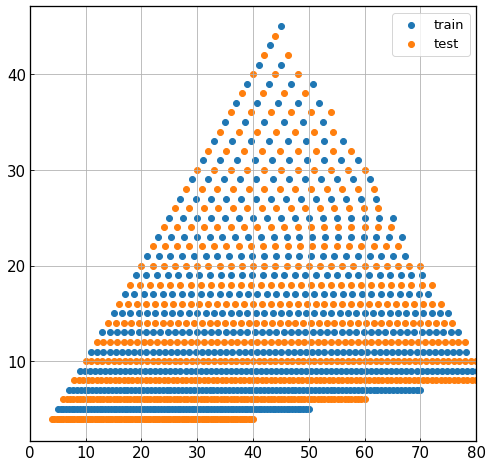

In [1]:
import sys, os
sys.path.append(os.path.abspath(''))   # 把当前目录设为引用模块的地址之一

from utils import *
from data_utils import *
from models.solver_cnn import *
from models.ConvNet import *

from data_utils import *
from data_noise import *

import mxnet as mx
import mxnet.ndarray as nd

import numpy as np
import pandas as pd
from itertools import product, permutations

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams['axes.linewidth'] = 1.3
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 13

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Easily Profile Python Code in Jupyter
# install conda install line_profiler or pip install line-profiler
# see http://mortada.net/easily-profile-python-code-in-jupyter.html
%load_ext line_profiler

test_ctx()

#############################
GW_address = './data/'

data = pd.DataFrame(np.load(GW_address+'GW_H1.npy'), index=np.load(GW_address+'GW_H1_index.npy'))
print(data.shape)
peak_samppoint = data.values.argmax(axis=1)
peak_samppoint = int(peak_samppoint.sum() / peak_samppoint.shape[0])
peak_time = peak_samppoint/data.shape[-1]
peak_time = float('{:.2f}'.format(peak_time))
print('Peak sampling point at %dth (%.2fs).' %(peak_samppoint, peak_time))
data.head()
# 波形数据


print('总波形数目：', data.index.shape)
train_masses = [(float(masses.split('|')[0]), float(masses.split('|')[1])) for masses in data.index if float(masses.split('|')[0]) % 2 != 0]
test_masses = [(float(masses.split('|')[0]), float(masses.split('|')[1])) for masses in data.index if float(masses.split('|')[0]) % 2 == 0]
print('训练集波形数目：', len(train_masses))
print('测试集波形数目：', len(test_masses))

train_m1, train_m2 = [ m[0] for m in train_masses],  [ m[1] for m in train_masses]
test_m1, test_m2 = [ m[0] for m in test_masses],  [ m[1] for m in test_masses]
plt.figure(figsize= (8,8))
plt.scatter(train_m2, train_m1, label='train')
plt.scatter(test_m2, test_m1, label = 'test')
plt.grid()
plt.legend()
plt.xlim(0,80)
# plt.title('训练集和测试集的波形在质量上的分布')
plt.show()

# 做好训练集和测试集的分割~

test_masses = [masses for masses in data.index if float(masses.split('|')[0]) % 2 == 0]
train_masses = [masses for masses in data.index if float(masses.split('|')[0]) % 2 != 0]
train_data = data.loc[train_masses]
test_data = data.loc[test_masses]

In [2]:
def ppp(data, fLow, fHigh, fs, shuffle = True):

    if shuffle:
        data, shift_list = shuffle_data_nd(nd.array(data, ctx=mx.cpu()),peak_samppoint, peak_time, 5)
        data = pd.DataFrame(data.asnumpy())

    b = nd.array(pre_fir(fLow=fLow, fHigh=fHigh, fs = fs).reshape((-1,1)), ctx=ctx)
    pp = pre_fftfilt(b, shape = data.shape, nfft=None)
    vline_list = []
    mf_list = []
    for snr in (np.array([0.01]+np.arange(0.05,1.04,0.05).tolist())):
        n = GenNoise_matlab_nd(shape = data.shape, params=pp)
        sigma_ = data.max(axis=1) / float(snr) / n.asnumpy().std(axis=1 , dtype = 'float64')
        signal_ = data.div(sigma_, axis=0)
        sim = signal_ + n.asnumpy()
        mf = SNR_MF(sim, n.asnumpy(), signal_)
#         print(mf.mean())
        plt.hist(mf , bins = 50, alpha = 0.6)
        plt.vlines(x = np.array(mf).mean(), ymin=0, ymax=90, alpha = 0.8)
        mf_list.append(mf)
        vline_list.append(np.array(mf).mean())
        print(snr)
    plt.show()
    print(vline_list)
    return mf_list

In [85]:
random_peak = np.concatenate(((data).values[300][600:], np.array([0,]*600)) ,)
type(ZERO_DET)

numpy.ndarray

## ASD & Strain

Comparison of the amplitude spectrum density (ASD) between one example of the simulated noise and the aLIGO “Zero-detuned High Power” design

fLow = 9, fHigh = 9000, fs = 8192, filtOrdr = 100


/Users/Herb/github/Python4GW/data_noise.py:204: ComplexWarning: Casting complex values to real discards the imaginary part
  y[istart-1:yend,:] = y[istart-1:yend,:] + Y[:(yend-istart+1),:]


Save or not? (y/n)n


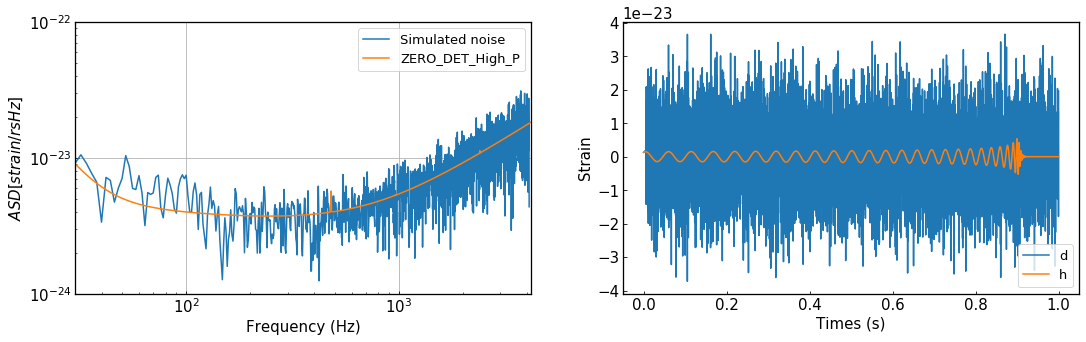

In [354]:
try:
    type(ZERO_DET)
except:
    url  = 'https://dcc.ligo.org/public/0002/T0900288/003/ZERO_DET_high_P.txt'
    raw_data=urllib.request.urlopen(url)
    ZERO_DET = np.loadtxt(raw_data)

random_peak = np.concatenate((data.loc['35.00|35.00':,:].values[0][1:], np.array([0,]*1)) ,)

b = pre_fir()
noise1 = GenNoise_matlab_np(shape = (10, 8192), b = b)[0]
# noise1 = GenNoise_matlab(nDataSamples = 8192, fLow = 9, fHigh = 9000, fs = 8192, filtOrdr = 100, debug = None)
from scipy.signal import welch
[f, pxx] = welch(x = noise1,nperseg=2048*2, fs = 8192)

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.loglog(f, np.sqrt(pxx*8192/2), label = 'Simulated noise')
plt.loglog(ZERO_DET[:,0],ZERO_DET[:,1], label = "ZERO_DET_High_P")
plt.xlabel('Frequency (Hz)')
# plt.ylabel('$[PSD]^{1/2}$')
plt.ylabel('$ASD [strain/rsHz]$')
plt.xlim(30,9000/2-300)
plt.ylim(1e-24,1e-22)
plt.legend()
plt.grid()

alpha = random_peak.max()/noise1.std()
snr = 0.5
plt.subplot(1,2,2)
plt.plot(np.linspace(0,1,8192), noise1+ random_peak/alpha*snr, label = 'd')
plt.plot(np.linspace(0,1,8192), random_peak/alpha*snr, label = 'h')
plt.xlabel('Times (s)')
plt.ylabel('Strain')
plt.legend(loc=4)

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ASD_Strain'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()

Save or not? (y/n)y
Saved in ./images/Strain.png
Saved in ./images/Strain.eps
Saved in ./images/Strain.pdf


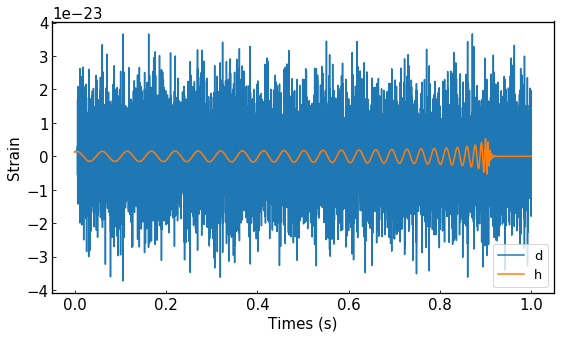

In [356]:
plt.figure(figsize=(9,5))
plt.plot(np.linspace(0,1,8192), noise1+ random_peak/alpha*snr, label = 'd')
plt.plot(np.linspace(0,1,8192), random_peak/alpha*snr, label = 'h')
plt.xlabel('Times (s)')
plt.ylabel('Strain')
plt.legend(loc=4)

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'Strain'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()

/Users/Herb/github/Python4GW/data_noise.py:204: ComplexWarning: Casting complex values to real discards the imaginary part
  y[istart-1:yend,:] = y[istart-1:yend,:] + Y[:(yend-istart+1),:]


Save or not? (y/n)y
Saved in ./images/ASD_Strain.png
Saved in ./images/ASD_Strain.eps
Saved in ./images/ASD_Strain.pdf


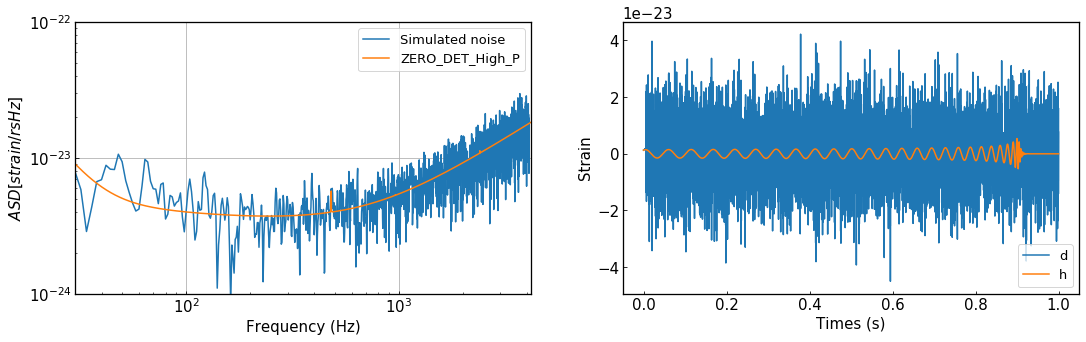

In [89]:
N = 8192
fs = 8192
fmin = 20
fmax = 9000

def oneSidedPeriodogram(y, fs):
    N = y.size
    yf = np.fft.fft(y)
    xf = np.fft.fftfreq(N, 1./fs)
    oneSidedPeriodogram = 2/fs*abs(yf[xf>=0])**2/N
    return yf, xf[xf>=0], oneSidedPeriodogram


def TimeseriesFromPSD(N = 8192, fs = 8192, fmin = 9, fmax = 4000):
    low_f_max = fmin
    high_f_min = fmax
    # Interpolation
    freqs = np.fft.fftfreq(N, 1./fs)
    asd_zero = np.interp(freqs[(freqs>=ZERO_DET[:,0].min())&(freqs<=high_f_min)], ZERO_DET[:,0], ZERO_DET[:,1]) 
    
    
    # Gauss noise and its one-sided PSD without window
    gauss_noise = 1* np.random.normal(loc=0,scale=64,size=N)
    _, xf_noise, psd_gauss = oneSidedPeriodogram(gauss_noise, fs)
    # psd_gauss ,xf_noise= plt.mlab.psd(gauss_noise, Fs=fs, NFFT=NFFT, window=psd_window, noverlap=NOVL)
    # xf_noise = xf_noise[1:]
    # psd_gauss = psd_gauss[1:]

    # Confirm the range of low frequency
#     shiftsize = 11
#     low_f_max = ZERO_DET[:,0].min() + shiftsize
#     high_f_min = 4000
    shiftsize = int(low_f_max - ZERO_DET[:,0].min())
    slc, slc_, slc__ = (xf_noise >= low_f_max)&(xf_noise<=high_f_min), (xf_noise < low_f_max), (xf_noise > high_f_min)

    # Two-sided PSD
    psd_twosided = np.hstack(( # low positive
                        psd_gauss[slc_] * 0
                       # high positive
                      , psd_gauss[slc][:] * (asd_zero**2)[shiftsize:]
                      , psd_gauss[slc__] * 0
                      , psd_gauss[slc__][::-1] * 0
                       # high negative
                      , psd_gauss[slc][:][::-1] *(asd_zero**2)[shiftsize:][::-1]
                       # low negative
                      , psd_gauss[slc_][::-1] * 0))

    np.random.seed()
    amplitude =  np.sqrt(psd_twosided *2 *fs*N )
    epsilon = np.random.rand(len(amplitude))*1j*2*np.pi
    return np.real(np.fft.ifft(amplitude*np.exp(epsilon))), psd_twosided   


# noise_sample, psd_zero = TimeseriesFromPSD(fmin=fmin, fmax=fmax)


random_peak = np.concatenate((data.loc['35.00|35.00':,:].values[0][1:], np.array([0,]*1)) ,)

# b = pre_fir()
# noise_sample = GenNoise_matlab_np(shape = (10, 8192), b = b)[0]
noise_sample = GenNoise_matlab(nDataSamples = 8192, fLow = 9, fHigh = 9000, fs = 8192, filtOrdr = 100, debug = None)
# from scipy.signal import welch
# [f, pxx] = welch(x = noise1,nperseg=2048*2, fs = 8192)

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)

# plt.loglog( np.sqrt(psd_zero[1:]), label = "Colored noise", alpha=0.7)

# Check#1
_, xf_noise_sample, PSD_noise_sample = oneSidedPeriodogram(noise_sample, fs)
# plt.loglog(xf_noise_sample[1:], np.sqrt(PSD_noise_sample[1:]*8192/2), label = "Simulated_mine", alpha=0.6)

# Check#2
NFFT = fs//2
# NFFT = 4*fs
psd_window = np.blackman(NFFT)
NOVL = NFFT/2
PSD_noise_sample ,xf_noise_sample= plt.mlab.psd(noise_sample, Fs=fs, NFFT=NFFT, window=psd_window, noverlap=NOVL)

plt.loglog(xf_noise_sample[1:], np.sqrt(PSD_noise_sample[1:]*8192/2), label = "Simulated noise", alpha=1)
plt.loglog(ZERO_DET[:,0],ZERO_DET[:,1], label = "ZERO_DET_High_P")
plt.xlabel('Frequency (Hz)')
# plt.ylabel('$[PSD]^{1/2}$')
plt.ylabel('$ASD [strain/rsHz]$')
plt.xlim(30,9000/2-300)
plt.ylim(1e-24,1e-22)
plt.legend()
plt.grid()


alpha = random_peak.max()/noise_sample.std()
snr = 0.5
plt.subplot(1,2,2)
plt.plot(np.linspace(0,1,8192), noise_sample+ random_peak/alpha*snr, label = 'd')
plt.plot(np.linspace(0,1,8192), random_peak/alpha*snr, label = 'h')
plt.xlabel('Times (s)')
plt.ylabel('Strain')
plt.legend(loc=4)




if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ASD_Strain'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()

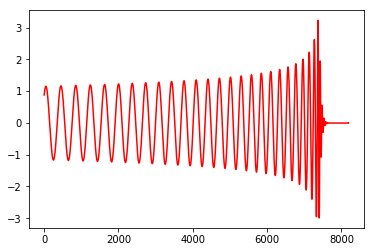

In [492]:
# plt.figure(figsize=(20,10))
random_peak = np.concatenate((Normolise(data).values[600][1:], np.array([0,]*1)) ,)
# plt.plot(Normolise(data).values[100], 'r')
plt.plot(random_peak, 'r')
plt.savefig('./images/waveform_dataflow0.png',dpi=300, bbox_inches='tight',transparent=False)

/Users/Herb/github/Python4GW/data_noise.py:204: ComplexWarning: Casting complex values to real discards the imaginary part
  y[istart-1:yend,:] = y[istart-1:yend,:] + Y[:(yend-istart+1),:]


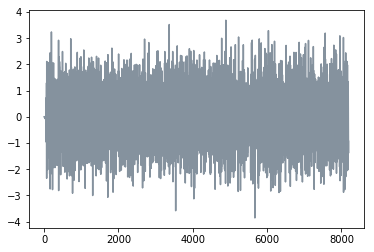

In [494]:
# plt.figure(figsize=(20,10))
noise = Normolise([GenNoise_matlab(nDataSamples=8192)])[0]
# plt.plot(noise)
# plt.plot(noise+ Normolise(data).values[300]/Normolise(data).values[300].max(),alpha=0.6, color='#34495e')
# plt.plot(Normolise(data).values[300]/Normolise(data).values[300].max(), 'r')
plt.plot(noise,alpha=0.6, color='#34495e')
# plt.plot(noise+ random_peak/random_peak.max(),alpha=0.6, color='#34495e')
# plt.plot(random_peak/random_peak.max(), 'r')
plt.savefig('./images/noise_dataflow1.png', dpi=300, bbox_inches='tight',transparent=False)

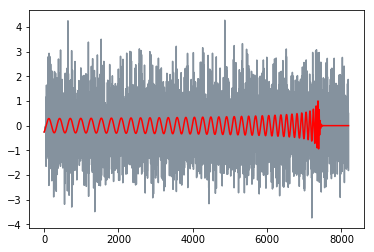

In [435]:
plt.plot(noise+ random_peak/random_peak.max(),alpha=0.6, color='#34495e')
plt.plot(random_peak/random_peak.max(), 'r')

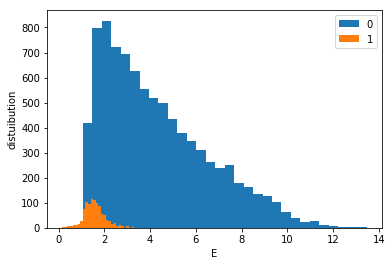

In [540]:
import matplotlib.pyplot as plt
import seaborn as sns

file_address = '/Users/Herb/Downloads/eta_3.csv'
df = pd.read_csv(file_address, header=1,delim_whitespace=True)
plt.hist(df[df.m == 0].E, bins=30, label = '0')
plt.hist(df[df.m == 1].E, bins=30, label= '1')
plt.xlabel('E')
plt.ylabel('distuibution')
plt.legend()

## Statistics of $\rho_{MF}$ for fixed $\rho_{amp}$. 

In each color, we fix a given $\rho_{amp}$, which is shown in the legend, and generate randomly data d = n + h, in which 5-fold expansion for h by peak-location randomization. For each simulated data we compute the corresponding $\rho_{MF}$ and count the numbers for each $\rho_{MF}$ range.

Save or not? (y/n)y
Saved in ./images/distributionsnr_mf_vs_snr_amp.pdf


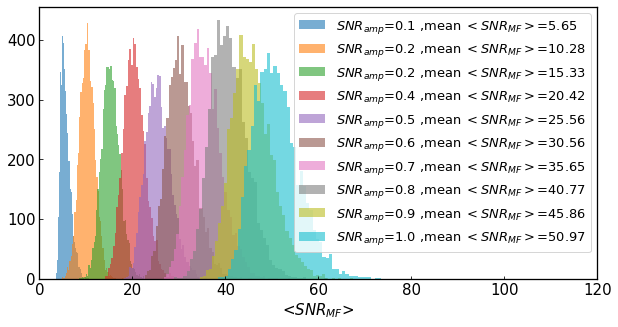

In [3]:
# snr_mf = ppp(data=data, fLow=9, fHigh=9000, fs = 8192)
# np.save('./images/data/snr_mf_5fold', snr_mf)
snr_mf = np.load('./images/data/snr_mf_5fold.npy')

plt.figure(figsize=(10,5))
for i, snr in enumerate(np.array([0.01]+np.arange(0.05,1.04,0.05).tolist())[1::2]):
    plt.hist(snr_mf[i*2+2] , bins = 50, alpha = 0.6, label = '$SNR_{amp}$=%.1f ,mean $<SNR_{MF}>$=%.2f' %(snr, np.array(snr_mf[i*2+2]).mean()))
plt.xlabel('<$SNR_{MF}$>')
plt.legend(loc='upper right')
plt.xlim(xmax=120)
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'distribution_snr_mf_vs_snr_amp.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'distributionsnr_mf_vs_snr_amp.pdf')
else:
    pass
plt.show()

In [205]:
tt = int(np.mean(snr_mf['50'])*100)/100
print('%.2f' %tt)


26.99


/Users/Herb/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


Save or not? (y/n)y
Saved in ./images/distribution_SNRmf_vs_SNRamp.png
Saved in ./images/distribution_SNRmf_vs_SNRamp.eps
Saved in ./images/distribution_SNRmf_vs_SNRamp.pdf


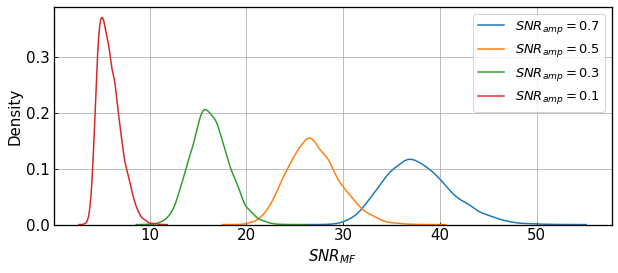

In [383]:
snr_mf = np.load('./images/data/test_mf_dict.npy').tolist()
hh=False
plt.figure(figsize=(10,4))
ll = int(np.mean(snr_mf['70'])*100)/100
sns.distplot(snr_mf['70'],hist=hh, bins=20,label = r'$SNR_{amp}=0.7$')
# plt.hist(snr_mf['70'], histtype='step', bins=30, label = r'$SNR_{amp}=0.7$'+'\n'+r'$<SNR_{MF}>$=%.2f' %ll )
ll = int(np.mean(snr_mf['50'])*100)/100
sns.distplot(snr_mf['50'],hist=hh, bins=20,label = r'$SNR_{amp}=0.5$')
# plt.hist(snr_mf['50'], histtype='step', bins=30, label = r'$SNR_{amp}=0.5$'+'\n'+r'$<SNR_{MF}>$=%.2f' %ll )
ll = int(np.mean(snr_mf['30'])*100)/100
sns.distplot(snr_mf['30'],hist=hh, bins=20,label = r'$SNR_{amp}=0.3$')
# plt.hist(snr_mf['30'], histtype='step', bins=30, label = r'$SNR_{amp}=0.3$'+'\n'+r'$<SNR_{MF}>$=%.2f' %ll )
ll = int(np.mean(snr_mf['10'])*100)/100
sns.distplot(snr_mf['10'],hist=hh, bins=20,label = r'$SNR_{amp}=0.1$')
# plt.hist(snr_mf['10'], histtype='step', bins=30, label = r'$SNR_{amp}=0.1$'+'\n'+r'$<SNR_{MF}>$=%.2f' %ll )

plt.xlabel(r'$SNR_{MF}$')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid()
# plt.xlim(xmax=62)

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'distribution_SNRmf_vs_SNRamp'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()

## SNR $\langle\rho_{MP}\rangle$ v.s $\rho_{amp}$

Relation between the averaged matched filtering SNR $\langle\rho_{MP}\rangle$ and $\rho_{amp}$ based on the statistics investigation (above Fig). Approximated linear relation is also shown in the plot.

Save or not? (y/n)y
Saved in ./images/snr_mf_vs_snr_amp.eps


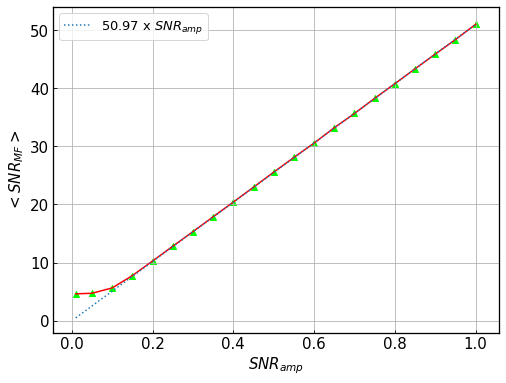

In [4]:
plt.figure(figsize=(8,6))
x = np.array([0.01]+np.arange(0.05,1.04,0.05).tolist())

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

plt.plot(x, snr_mf_mean, 'r-')
plt.plot(x, x*snr_mf_mean[-1], ls='dotted', label = '%.2f x $SNR_{amp}$' %snr_mf_mean[-1])
plt.scatter(np.array([0.01]+np.arange(0.05,1.04,0.05).tolist()), snr_mf_mean,marker='^', c='lime')
plt.xlabel('$SNR_{amp}$')
plt.ylabel('$<SNR_{MF}>$')
plt.legend()
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'snr_mf_vs_snr_amp.eps', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'snr_mf_vs_snr_amp.eps')
else:
    pass
plt.show()

Save or not? (y/n)y
Saved in ./images/mean_SNRmf_vs_SNRamp.png
Saved in ./images/mean_SNRmf_vs_SNRamp.eps
Saved in ./images/mean_SNRmf_vs_SNRamp.pdf


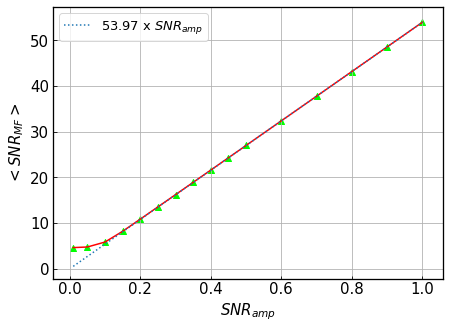

In [271]:
snr_mf = np.load('./images/data/test_mf_dict.npy').tolist()
SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
snr_mf_mean = []
for snr in SNR_list:
    snr_mf_mean.append(np.mean(snr_mf['%s' %int(snr*100)]))

plt.figure(figsize=(7,5))
plt.plot(SNR_list[::-1], snr_mf_mean[::-1], 'r-')
plt.plot(SNR_list[::-1], np.array(SNR_list[::-1]) * snr_mf_mean[0], ls='dotted', label = r'%.2f x $SNR_{amp}$' %snr_mf_mean[0])
plt.scatter(SNR_list[::-1], snr_mf_mean[::-1],marker='^', c='lime')
plt.xlabel(r'$SNR_{amp}$')
plt.ylabel(r'$<SNR_{MF}>$')
plt.legend()
plt.grid()
# plt.legend(loc='upper right')

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'mean_SNRmf_vs_SNRamp'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()

## ROC comparison among different $\rho_{MF}$ of training data

Automatically created module for IPython interactive environment
Save or not? (y/n)y
Saved in ./images/ROC_comparison_training_586.png
Saved in ./images/ROC_comparison_training_586.eps
Saved in ./images/ROC_comparison_training_586.pdf


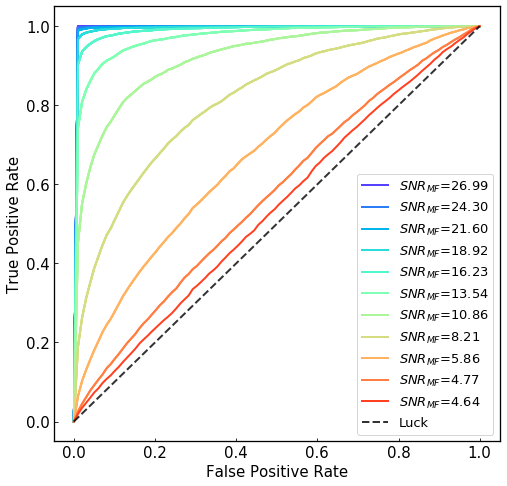

In [121]:
# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
print(__doc__)
tpr_old_again = np.load('./AUC_data/tpr_old_again.npy').tolist()
fpr_old_again = np.load('./AUC_data/fpr_old_again.npy').tolist()

low = None
SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
SNR_MF_list = [26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64]

from scipy import interp
mean_fpr = np.linspace(0, 1, 100)
snr_training = 8
snr_testings = 11


# plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
mean_tpr_list = []
index_list = []
for snr_testing in range(0,snr_testings):
    tprs = []
#     for i in range(5):
    tprs.append(interp(mean_fpr
               ,fpr_old_again[snr_training][snr_testing]
               ,tpr_old_again[snr_training][snr_testing]).tolist())
    tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr_list.append(mean_tpr.tolist())
    index_list.append('%s' %['$SNR_{MF}$=%.2f' %snr for snr in SNR_MF_list][snr_testing])
#     plt.plot(mean_fpr, mean_tpr, lw=2, alpha=.8,
#              label = '%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
    df = pd.DataFrame(mean_tpr_list, index = index_list)
#     df.T.plot(x=mean_fpr, ax=ax, color=sns.color_palette('Oranges_r', snr_testings), lw=2, alpha=.8)
#     df.T.plot(x=mean_fpr, ax=ax, color=sns.color_palette("Paired", snr_testings), lw=2)
    df.T.plot(x=mean_fpr, ax=ax, color=sns.color_palette("rainbow", snr_testings), lw=2)
        
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(ncol = 1, loc="lower right")

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ROC_comparison_training_' + str(int(SNR_MF_list[snr_training]*100))
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass

plt.show()

Automatically created module for IPython interactive environment
Save or not? (y/n)y
Saved in ./images/ROC_comparison_training.eps


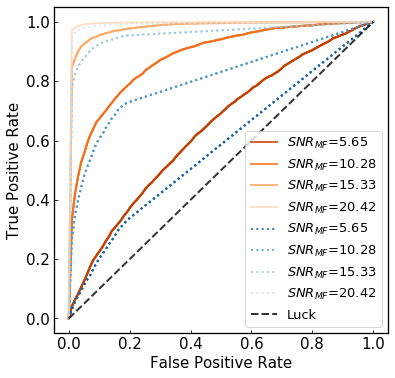

In [5]:
# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
print(__doc__)
tpr_OURs_new2 = np.load('./AUC_data/tpr_OURs_new2.npy')
fpr_OURs_new2 = np.load('./AUC_data/fpr_OURs_new2.npy')

tpr_OURs_2localnoise10 = np.load('./AUC_data/tpr_OURs_2localnoise10.npy')
fpr_OURs_2localnoise10 = np.load('./AUC_data/fpr_OURs_2localnoise10.npy')

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

from scipy import interp
mean_fpr = np.linspace(0, 1, 100)
snr_training = 0
snr_testings = 4


# plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
mean_tpr_list = []
index_list = []
for snr_testing in range(0,snr_testings):
    tprs = []
    for i in range(5):
        tprs.append(interp(mean_fpr, 
                           fpr_OURs_new2[snr_training,snr_testing][i], 
                           tpr_OURs_new2[snr_training,snr_testing][i]).tolist())
        tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr_list.append(mean_tpr.tolist())
    index_list.append('%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
#     plt.plot(mean_fpr, mean_tpr, lw=2, alpha=.8,
#              label = '%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
    df = pd.DataFrame(mean_tpr_list, index = index_list)
    df.T.plot(x=mean_fpr, ax=ax, color=sns.color_palette('Oranges_r', snr_testings), lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

mean_tpr_list = []
index_list = []    
for snr_testing in range(0,snr_testings):
    tprs = []
    for i in range(5):
        tprs.append(interp(mean_fpr, 
                           fpr_OURs_2localnoise10[snr_training,snr_testing][i], 
                           tpr_OURs_2localnoise10[snr_training,snr_testing][i]).tolist())
        tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr_list.append(mean_tpr.tolist())
    index_list.append('%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
#     plt.plot(mean_fpr, mean_tpr, lw=2, alpha=.8,
#              label = '%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
    df = pd.DataFrame(mean_tpr_list, index = index_list)
    df.T.plot(x=mean_fpr, ax=ax, color=sns.color_palette('Blues_r', snr_testings),linestyle=':' ,lw=2, alpha=.8)  

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(ncol = 1, loc="lower right")

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'ROC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'ROC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'ROC_comparison_training.eps')
else:
    pass

plt.show()

## AUC comparison among different $\rho_{MF}$ of training data

In [6]:
# AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
# AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
# AUC_OURs_2localnoise1 = np.load('./AUC_data/AUC_OURs_2localnoise1.npy')
# AUC_OURs_2localnoise5 = np.load('./AUC_data/AUC_OURs_2localnoise5.npy')
AUC_OURs_2localnoise10 = np.load('./AUC_data/AUC_OURs_2localnoise10.npy')
# AUC_OURs_new3_localnoise = np.load('./AUC_data/AUC_OURs_new3_localnoise.npy')

Save or not? (y/n)y
Saved in ./images/AUC_comparison_training.eps


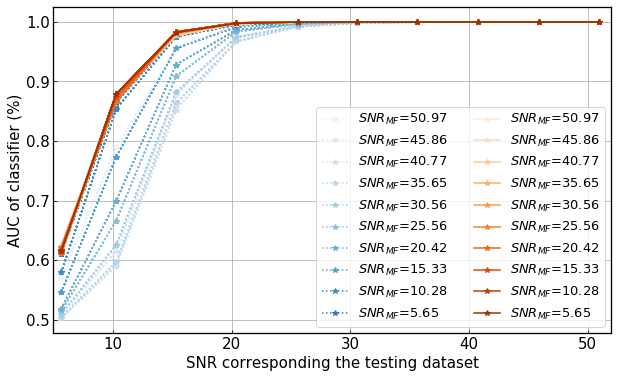

In [7]:
# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
df = pd.DataFrame(AUC_OURs_2localnoise10.min(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], 
                  columns=snr_mf_mean[2::2])
for i in range(AUC_OURs_2localnoise10.shape[0]):
    df.T.plot(marker= '*',linestyle=':', ax=ax, color=sns.color_palette('Blues', 13), alpha = 1)    

df = pd.DataFrame(AUC_OURs.min(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], 
                  columns=snr_mf_mean[2::2])    
for i in range(AUC_OURs.shape[0]):
    df.T.plot(marker= '*', ax=ax, color=sns.color_palette("Oranges", 10), alpha = 1)    
ax.legend(ncol=2, loc='best')
ax.set_xlim(5, 52)
ax.set_ylabel('AUC of classifier (%)')
ax.set_xlabel('SNR corresponding the testing dataset')
ax.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'AUC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'AUC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'AUC_comparison_training.eps')
else:
    pass
plt.show()

## Asymptotical accuracy of signal recognizing 

The relation between the asymptotical accuracy of signal recognizing and the SNR $\rho_{MF}$ of the training / testing data.


In [8]:
acc_training_list =  []
acc_testing_list =  []

acc_training_list_finitenoise =  []
acc_testing_list_finitenoise =  []
for i in range(1,11):
    os.system('ls -a ./pretrained_models/OURs_new/snr_%s_best* > test.txt' %(i*10))
    params_adds = pd.read_csv('./test.txt', header=None)
    os.system('rm test.txt')
    where_stop = params_adds[0].map(lambda x: int(x.split('_')[6].split('@')[1]))
    acc_training_list.append(nd.load('./pretrained_models/OURs_new/snr_%s_info.pkl' %(i*10))['train_acc_history'].asnumpy()[where_stop-1][0].tolist())
    acc_testing_list.append(nd.load('./pretrained_models/OURs_new/snr_%s_info.pkl' %(i*10))['test_acc_history'].asnumpy()[where_stop-1][0].tolist())
    
    os.system('ls -a ./pretrained_models/OURs_2finitenoise10/snr_%s_best* > test.txt' %(i*10))
    params_adds = pd.read_csv('./test.txt', header=None)
    os.system('rm test.txt')
    where_stop = params_adds[0].map(lambda x: int(x.split('_')[6].split('@')[1]))
    acc_training_list_finitenoise.append(nd.load('./pretrained_models/OURs_2finitenoise10/snr_%s_info.pkl' %(i*10))['train_acc_history'].asnumpy()[where_stop-1][0].tolist())
    acc_testing_list_finitenoise.append(nd.load('./pretrained_models/OURs_2finitenoise10/snr_%s_info.pkl' %(i*10))['test_acc_history'].asnumpy()[where_stop-1][0].tolist())

Save or not? (y/n)y
Saved in ./images/asymptotical_acc.eps


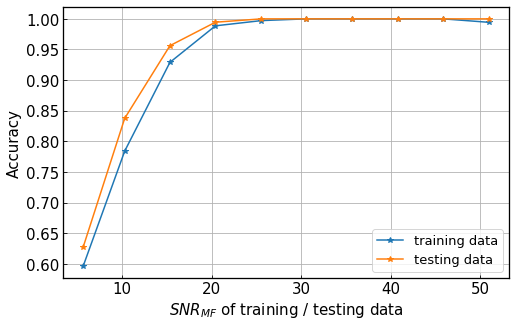

In [9]:
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(snr_mf_mean[2::2], acc_training_list, '*-', label = 'training data')
plt.plot(snr_mf_mean[2::2], acc_testing_list, '*-', label = 'testing data')
plt.xlabel('$SNR_{MF}$ of training / testing data')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'asymptotical_acc.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'asymptotical_acc.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'asymptotical_acc.eps')
else:
    pass

plt.show()


# plt.plot(acc_training_list_finitenoise, label = 'train_local')
# plt.plot(acc_testing_list_finitenoise, label = 'test_local')
# plt.legend()


## Fine-tune number of MLP layers

[1.0, 1.0, 0.99999888581363738, 0.99993658968789501, 0.99973374222953315, 0.99905631692109154, 0.99693547410333772, 0.99044763245447498, 0.97003151093807682, 0.91317210670706983, 0.79970640424708617, 0.65893888124154099, 0.5573468607646308, 0.52439170230897869]


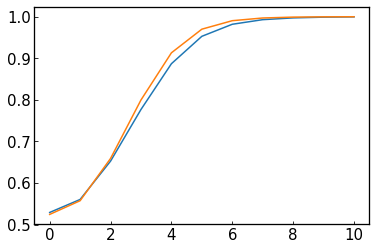

In [42]:
(AUC_OURs['100'])
print(AUC_OURs['%s' %int(0.1*100)])
plt.plot(AUC_num_MLP2['%s' %int(0.1*100)][::-1])
plt.plot(AUC_OURs['%s' %int(0.1*100)][3:][::-1])


0.1
Save or not? (y/n)y
Saved in ./images/ACC_finetune_MLP123.png
Saved in ./images/ACC_finetune_MLP123.eps
Saved in ./images/ACC_finetune_MLP123.pdf


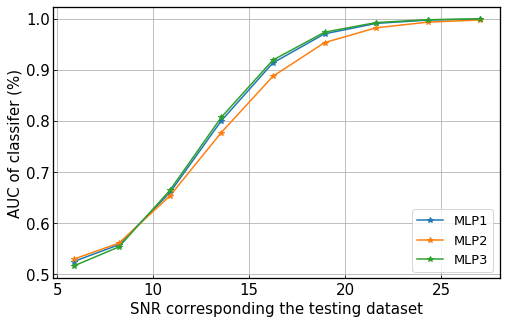

MLP1


In [127]:
AUC_num_MLP2 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_MLP2MLP.npy').tolist()
AUC_num_MLP3 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_MLP3MLP.npy').tolist()
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

# SNR_test_list =[(16*2**i,) for i in range(4+1)[::-1]] 
plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    print(SNR_)
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'MLP1')
    plt.plot(SNR_MF_list[::-1], AUC_num_MLP2['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'MLP2')
    plt.plot(SNR_MF_list[::-1], AUC_num_MLP3['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'MLP3')
    break

plt.legend(loc='lower right')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_finetune_MLP123'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass

plt.show()
# print(AUC_OURs.mean(axis=2)[-1].sum())
# print(AUC_fc_params.mean(axis=2).sum(axis=1))
print('MLP1')
# print(scipy.integrate.simps(AUC_OURs.mean(axis=2)[-1],snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))
# print(scipy.integrate.simps( AUC_fc_params.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune number of MLP neurals

Save or not? (y/n)y
Saved in ./images/ACC_finetune_num_neurals.png
Saved in ./images/ACC_finetune_num_neurals.eps
Saved in ./images/ACC_finetune_num_neurals.pdf


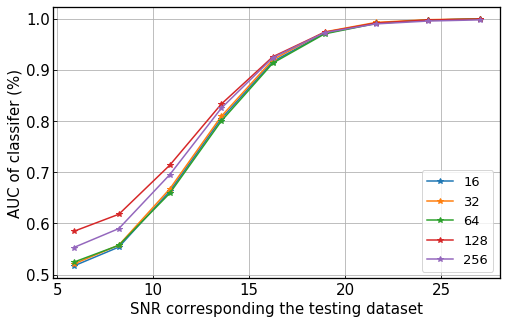

128


In [126]:
AUC_num_fc_16 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_fc1600.npy').tolist()
AUC_num_fc_32 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_fc3200.npy').tolist()
AUC_num_fc_128 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_fc12800.npy').tolist()
AUC_num_fc_256 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_fc25600.npy').tolist()
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

# SNR_test_list =[(16*2**i,) for i in range(4+1)[::-1]] 
plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_num_fc_16['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '16')
    plt.plot(SNR_MF_list[::-1], AUC_num_fc_32['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '32')
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = '64')
    plt.plot(SNR_MF_list[::-1], AUC_num_fc_128['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '128')        
    plt.plot(SNR_MF_list[::-1], AUC_num_fc_256['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '256')        
    break
plt.legend(loc='lower right')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_finetune_num_neurals'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass

plt.show()
# print(AUC_num_filter.mean(axis=2).sum(axis=1))
print('128')
# print(scipy.integrate.simps( AUC_num_filter.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune dropout of MLP

Save or not? (y/n)y
Saved in ./images/ACC_finetune_dropout.png
Saved in ./images/ACC_finetune_dropout.eps
Saved in ./images/ACC_finetune_dropout.pdf


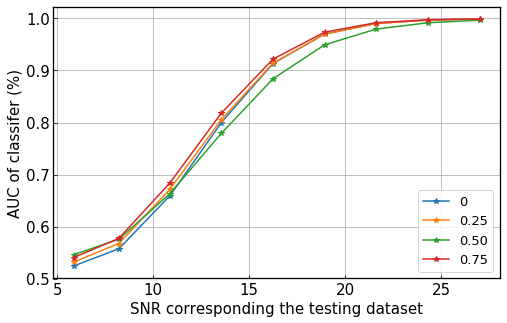

0.75


In [128]:
AUC_dropout25 = np.load('./AUC_data/AUC_OURs_old_newNoise_dropout25.npy').tolist()
AUC_dropout50 = np.load('./AUC_data/AUC_OURs_old_newNoise_dropout50.npy').tolist()
AUC_dropout75 = np.load('./AUC_data/AUC_OURs_old_newNoise_dropout75.npy').tolist()
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]


plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-2]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = '0')
    plt.plot(SNR_MF_list[::-1], AUC_dropout25['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '0.25')
    plt.plot(SNR_MF_list[::-1], AUC_dropout50['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '0.50')
    plt.plot(SNR_MF_list[::-1], AUC_dropout75['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '0.75')        
    break
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc='lower right')

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_finetune_dropout'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
# plt.xlim(0,7)
plt.show()
# print(AUC_dropout.mean(axis=2).sum(axis=1))
print('0.75')
# print(scipy.integrate.simps( AUC_dropout.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune type of activation

Save or not? (y/n)y
Saved in ./images/ACC_finetune_Active.png
Saved in ./images/ACC_finetune_Active.eps
Saved in ./images/ACC_finetune_Active.pdf


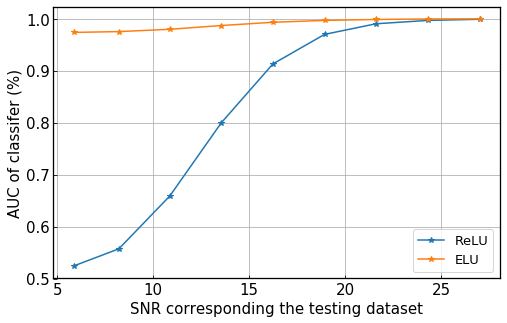

ELU


In [129]:
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()
AUC_act = np.load('./AUC_data/AUC_OURs_old_newNoise_eluelu.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)


plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'ReLU')
    plt.plot(SNR_MF_list[::-1], AUC_act['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'ELU')
    break
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc='lower right')

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_finetune_Active'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
# plt.xlim(4,20)
plt.show()
# print(AUC_act.mean(axis=2).sum(axis=1))
print('ELU')
# print(scipy.integrate.simps( AUC_act.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune number of feature maps

Save or not? (y/n)y
Saved in ./images/ACC_finetune_featuremaps.png
Saved in ./images/ACC_finetune_featuremaps.eps
Saved in ./images/ACC_finetune_featuremaps.pdf


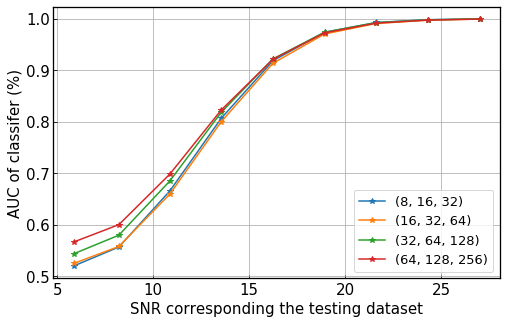

(64, 128, 256)


In [134]:
AUC_num_filter1_2 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_filter1_2.npy').tolist()
AUC_num_filter2 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_filter2.npy').tolist()
AUC_num_filter4 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_filter4.npy').tolist()
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

# SNR_test_list =[(16*2**i,) for i in range(4+1)[::-1]] 
plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_num_filter1_2['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '%s' %str((16//2,32//2,64//2)))
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = '%s' %str((16*1,32*1,64*1)))    
    plt.plot(SNR_MF_list[::-1], AUC_num_filter2['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '%s' %str((16*2,32*2,64*2)))
    plt.plot(SNR_MF_list[::-1], AUC_num_filter4['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '%s' %str((16*4,32*4,64*4)))        
    break
plt.legend(loc='lower right')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_finetune_featuremaps'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass

plt.show()
# print(AUC_num_filter.mean(axis=2).sum(axis=1))
print('%s' %str((16*4,32*4,64*4)))
# print(scipy.integrate.simps( AUC_num_filter.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune dialution

Save or not? (y/n)y
Saved in ./images/ACC_finetune_dilute.png
Saved in ./images/ACC_finetune_dilute.eps
Saved in ./images/ACC_finetune_dilute.pdf


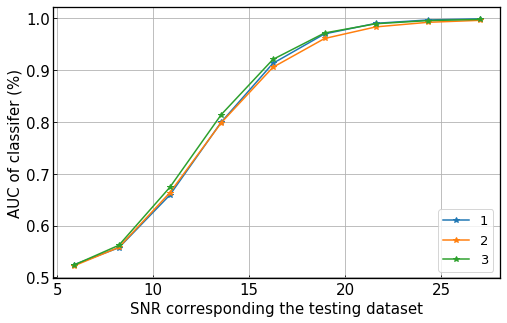

3


In [131]:
AUC_num_dialute2 = np.load('./AUC_data/AUC_OURs_old_newNoise_delate2.npy').tolist()
AUC_num_dialute3 = np.load('./AUC_data/AUC_OURs_old_newNoise_dilate3.npy').tolist()
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

# SNR_test_list =[(16*2**i,) for i in range(4+1)[::-1]] 
plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = '1')
    plt.plot(SNR_MF_list[::-1], AUC_num_dialute2['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '2')
    plt.plot(SNR_MF_list[::-1], AUC_num_dialute3['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '3')
    break
plt.legend(loc='lower right')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_finetune_dilute'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
# plt.xlim(0,6)
plt.show()
# print(AUC_dialution.mean(axis=2).sum(axis=1))
print('3')
# print(scipy.integrate.simps( AUC_dialution.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune pooling layers

Save or not? (y/n)y
Saved in ./images/ACC_finetune_poolingtype.png
Saved in ./images/ACC_finetune_poolingtype.eps
Saved in ./images/ACC_finetune_poolingtype.pdf


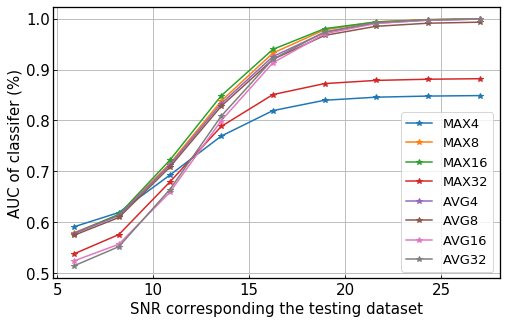

max16/max8


In [132]:
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()
AUC_MAX32 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingmax32.npy').tolist()
AUC_MAX16 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingmax16.npy').tolist()
AUC_MAX8 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingmax8.npy').tolist()
AUC_MAX4 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingmax4.npy').tolist()
AUC_AVG32 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingavg32.npy').tolist()
AUC_AVG8 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingavg8.npy').tolist()
AUC_AVG4 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingavg4.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)


plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_MAX4['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'MAX4')
    plt.plot(SNR_MF_list[::-1], AUC_MAX8['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'MAX8')
    plt.plot(SNR_MF_list[::-1], AUC_MAX16['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'MAX16')
    plt.plot(SNR_MF_list[::-1], AUC_MAX32['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'MAX32')
    plt.plot(SNR_MF_list[::-1], AUC_AVG4['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'AVG4')
#     plt.plot(SNR_MF_list[::-1], AUC_AVG8['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'AVG8')    
    plt.plot(SNR_MF_list[::-1], np.array(AUC_AVG4['%s' %int(SNR_*100)][::-1][:-2])*0.994, '*-',label = 'AVG8')    
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'AVG16')    
    plt.plot(SNR_MF_list[::-1], AUC_AVG32['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'AVG32')

    break
plt.legend(loc='lower right')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_finetune_poolingtype'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
# plt.xlim(0,6)
plt.show()
# print(AUC_pool_params.mean(axis=2).sum(axis=1))
print('max16/max8')
# print(scipy.integrate.simps( AUC_pool_params.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune convlution layers

Save or not? (y/n)y
Saved in ./images/ACC_finetune_ConvLayers.png
Saved in ./images/ACC_finetune_ConvLayers.eps
Saved in ./images/ACC_finetune_ConvLayers.pdf


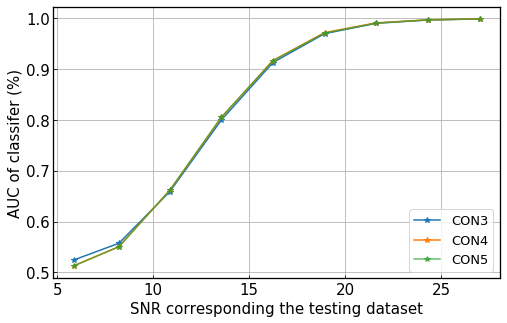

CNN3


In [133]:
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()
AUC_CONV1 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_CONV1CONV.npy').tolist()
AUC_CONV2 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_CONV2CONV.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)


plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'CON3')
    plt.plot(SNR_MF_list[::-1], AUC_CONV1['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'CON4')
    plt.plot(SNR_MF_list[::-1], AUC_CONV2['%s' %int(SNR_*100)][::-1][:-2], '*-',alpha=0.7,label = 'CON5')
    break
plt.legend(loc='lower right')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_finetune_ConvLayers'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()
# print(AUC_conv_params.mean(axis=2).sum(axis=1))
print('CNN3')
# print(scipy.integrate.simps( AUC_conv_params.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

Save or not? (y/n)y
Saved in ./images/model_compare.eps


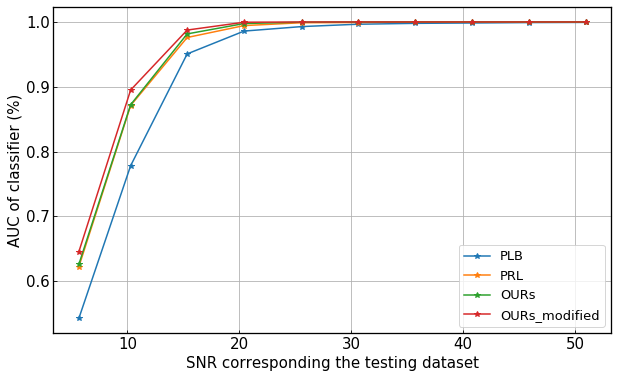

In [19]:
AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_PLB = AUC_PLB[:,1::2,:][:,::-1,:]
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
AUC_OURs_modified = np.load('./AUC_data/AUC_OURs_modified.npy')

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

plt.figure(figsize=(10,6))
plt.plot(snr_mf_mean[2::2], AUC_PLB.mean(axis=2)[0] , '*-',label = 'PLB')
plt.plot(snr_mf_mean[2::2], AUC_PRL.min(axis=2)[0] , '*-' ,label = 'PRL')
plt.plot(snr_mf_mean[2::2], AUC_OURs.min(axis=2)[0] , '*-',label = 'OURs')
plt.plot(snr_mf_mean[2::2], AUC_OURs_modified.max(axis=2)[0] , '*-',label = 'OURs_modified')
# plt.plot(AUC_PLB.mean(axis=2)[AUC_PLB.mean(axis=2).sum(axis=1).argmax()] ,label = 'PLB_max')
# plt.plot(AUC_PRL.mean(axis=2)[AUC_PRL.mean(axis=2).sum(axis=1).argmax()] ,label = 'PRL_max')
# plt.plot(AUC_OURs.mean(axis=2)[AUC_OURs.mean(axis=2).sum(axis=1).argmax()] ,label = 'OURs_max')
plt.ylabel('AUC of classifier (%)')
plt.xlabel('SNR corresponding the testing dataset')
plt.grid()
plt.legend(loc=4)
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'model_compare.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'model_compare.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'model_compare.eps')
else:
    pass
plt.show()
# plt.xlim(0, 3)

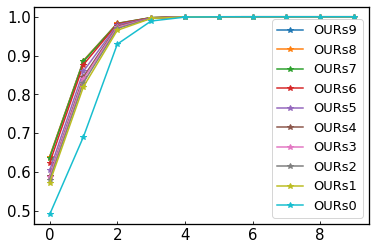

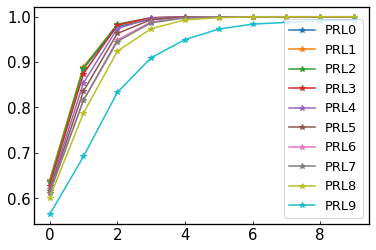

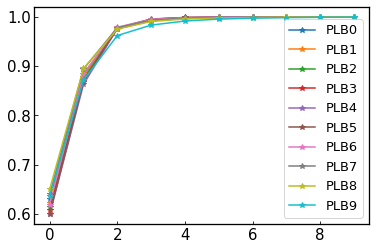

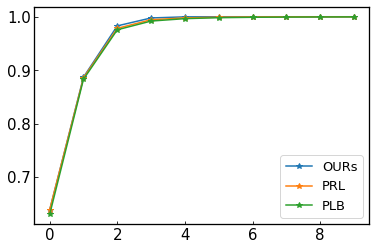

In [8]:
AUC_OURs = np.load('./AUC_data/AUC_old.npy')
AUC_PRL = np.load('./AUC_data/AUC_PRL_old.npy')
AUC_PLB = np.load('./AUC_data/AUC_PLB_old.npy')
for i in range(10)[::-1]:
    plt.plot(AUC_OURs.min(axis=2)[i] , '*-',label = 'OURs'+str(i))
plt.legend()
plt.show()

for i in range(10):
    plt.plot(AUC_PRL.min(axis=2)[i] , '*-',label = 'PRL'+str(i))
plt.legend()
plt.show()

for i in range(10):
    plt.plot(AUC_PLB.min(axis=2)[i] , '*-',label = 'PLB'+str(i))
plt.legend()
plt.show()

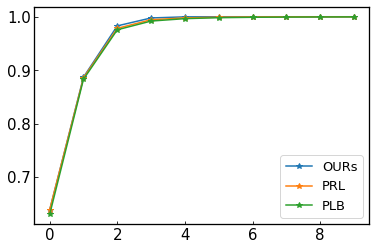

In [11]:
plt.plot(AUC_OURs.min(axis=2)[::-1][0] , '*-',label = 'OURs')
plt.plot(AUC_PRL.min(axis=2)[0] , '*-',label = 'PRL')
plt.plot(AUC_PLB.min(axis=2)[0] , '*-',label = 'PLB')
plt.legend()

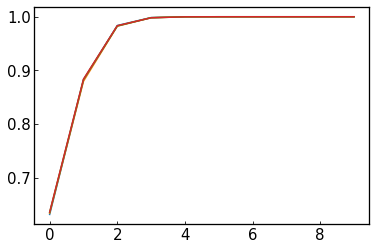

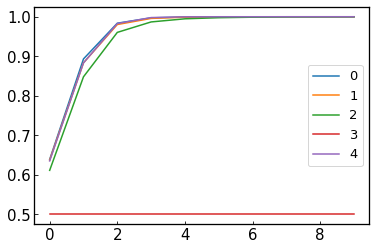

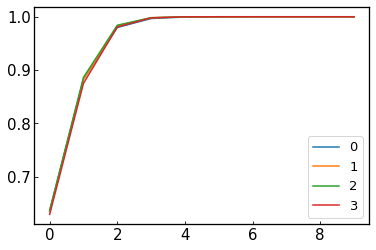

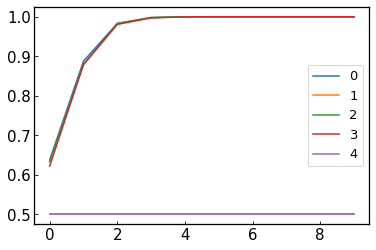

In [18]:
AUC_dropout = np.load('./AUC_data/AUC_OURs_old_dropout.npy')
AUC_dialute = np.load('./AUC_data/AUC_OURs_old_ft_dialute.npy')
AUC_num_filter = np.load('./AUC_data/AUC_OURs_old_ft_num_filter.npy')
AUC_hidden_dim = np.load('./AUC_data/AUC_OURs_old_ft_hidden_dim.npy')

for i in range(AUC_dropout.shape[0]):
    plt.plot(AUC_dropout.mean(axis=2)[i])
plt.show()

for i in range(AUC_dialute.shape[0]):
    plt.plot(AUC_dialute.mean(axis=2)[i], label = i)
plt.legend()
plt.show()

for i in range(AUC_num_filter.shape[0]):
    plt.plot(AUC_num_filter.mean(axis=2)[i], label = i)
plt.legend()
plt.show()

for i in range(AUC_hidden_dim.shape[0]):
    plt.plot(AUC_hidden_dim.mean(axis=2)[i], label = i)
plt.legend()
plt.show()

In [40]:
!ls images/

AUC_comparison_training.eps        fine_tune_num_MLPneurals.pdf
AUC_comparison_training.pdf        fine_tune_num_convlayers.eps
ROC_comparison_training.eps        fine_tune_num_convlayers.pdf
ROC_comparison_training.pdf        fine_tune_num_featuremaps.eps
asymptotical_acc.eps               fine_tune_num_featuremaps.pdf
asymptotical_acc.pdf               fine_tune_poolinglayer.eps
data                               fine_tune_poolinglayer.pdf
dataflow.pages                     fine_tune_type_activation.eps
dataflow.svg                       fine_tune_type_activation.pdf
distribution_snr_mf_vs_snr_amp.eps model_compare.eps
distribution_snr_mf_vs_snr_amp.pdf model_compare.pdf
fine_tune_dialute.eps              noise_dataflow1.png
fine_tune_dialute.pdf              snr_mf_vs_snr_amp.eps
fine_tune_dropout.eps              structure_OURs_PRL_PLB.eps
fine_tune_dropout.pdf              structure_OURs_PRL_PLB.pdf
fine_tune_num_MLPlayers.eps        structure_OURs_PRL_PLB.svg
fine_tune_num_MLPlay

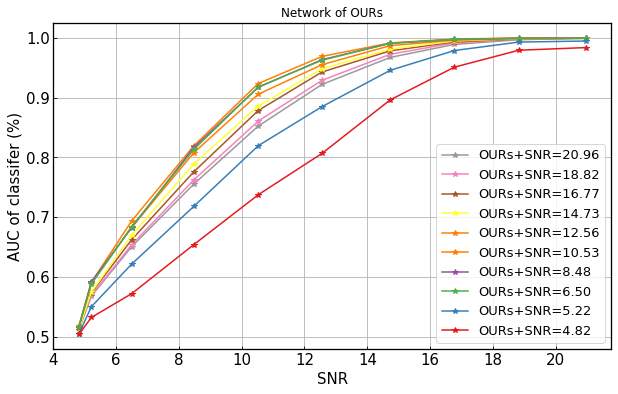

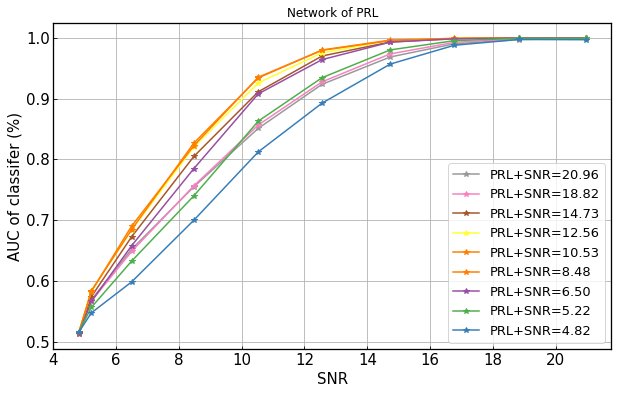

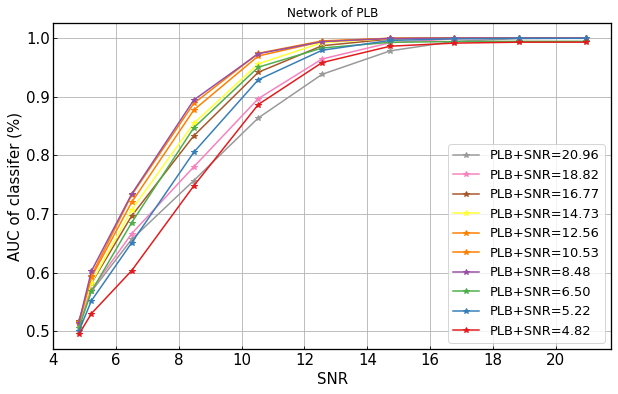

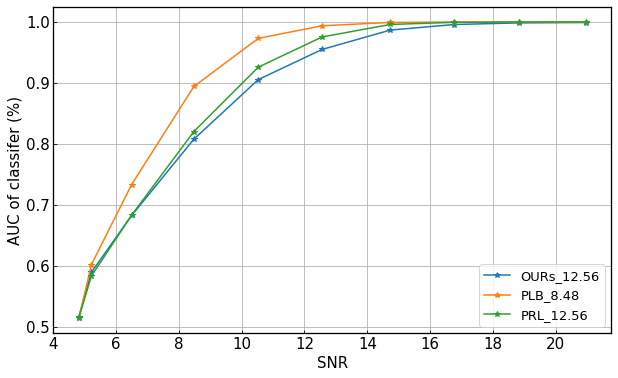

In [43]:
AUC_OURs = np.load('./AUC_data/AUC_OURs_oldversion.npy').tolist()
AUC_PRL = np.load('./AUC_data/AUC_PRL_oldversion.npy').tolist()
AUC_PLB = np.load('./AUC_data/AUC_PLB_oldversion.npy').tolist()

SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_MF_list = [20.96, 18.82, 16.77, 14.73, 12.56, 10.53, 8.48, 6.50, 5.22, 4.82]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):
        plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], '*-',label = 'OURs+'+index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_oldversion.pdf', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    if SNR_ == 0.8: continue
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(SNR_*10)][::-1] , '*-',label = 'PRL+'+index[i])
plt.grid()
plt.title('Network of PRL')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PRL_oldversion.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(SNR_*10)][::-1] , '*-',label = 'PLB+'+index[i])
plt.grid()
plt.title('Network of PLB')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PLB_oldversion.pdf', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10,6))
plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(0.6*10)][::-1] , '*-',label = 'OURs_12.56')
plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(0.4*10)][::-1] , '*-',label = 'PLB_8.48')
# plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(0.2*10)][::-1] , '*-',label = 'PLB_0.2')
plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(0.6*10)][::-1] , '*-',label = 'PRL_12.56')
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_models_oldversion.pdf', dpi=300, bbox_inches='tight')
plt.show()

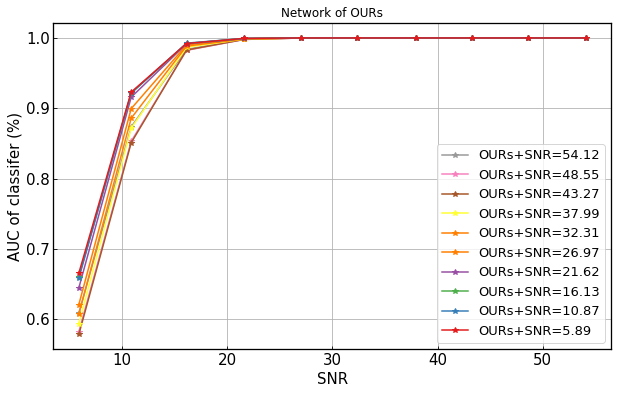

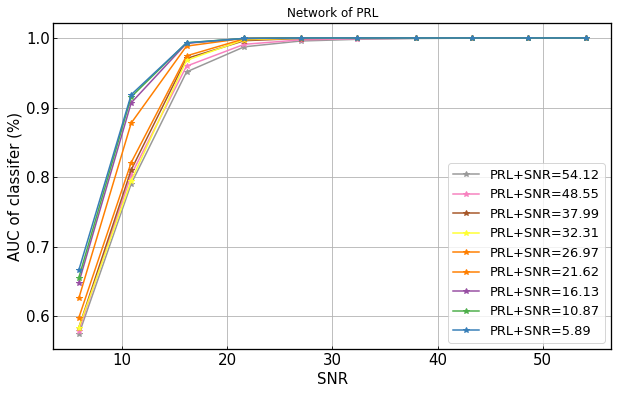

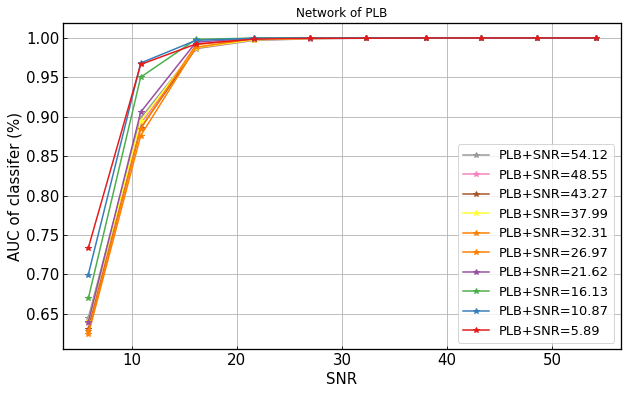

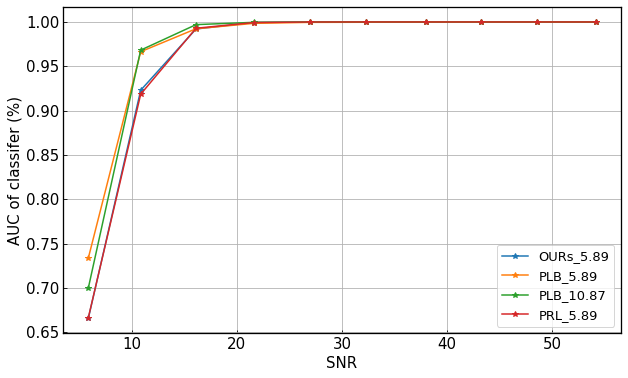

In [44]:
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise.npy').tolist()
AUC_PRL = np.load('./AUC_data/AUC_PRL_old_newNoise.npy').tolist()
AUC_PLB = np.load('./AUC_data/AUC_PLB_old_newNoise.npy').tolist()

SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):
        plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], '*-',label = 'OURs+'+index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_old_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    if SNR_ == 0.8: continue
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(SNR_*10)][::-1] , '*-',label = 'PRL+'+index[i])
plt.grid()
plt.title('Network of PRL')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PRL_old_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(SNR_*10)][::-1] , '*-',label = 'PLB+'+index[i])
plt.grid()
plt.xlabel('SNR')
plt.title('Network of PLB')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PLB_old_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10,6))
plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(0.1*10)][::-1] , '*-',label = 'OURs_5.89')
plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(0.1*10)][::-1] , '*-',label = 'PLB_5.89')
plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(0.2*10)][::-1] , '*-',label = 'PLB_10.87')
plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(0.1*10)][::-1] , '*-',label = 'PRL_5.89')
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_models_old_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()

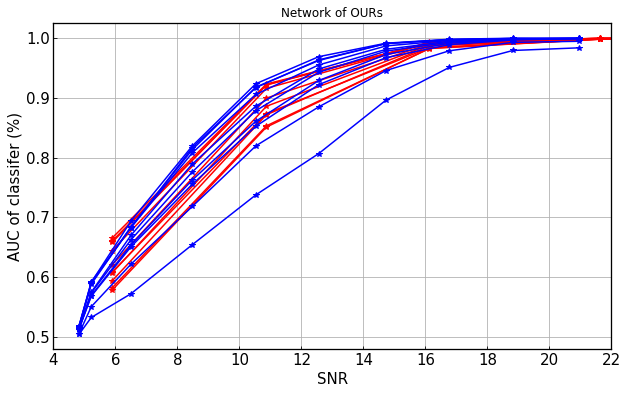

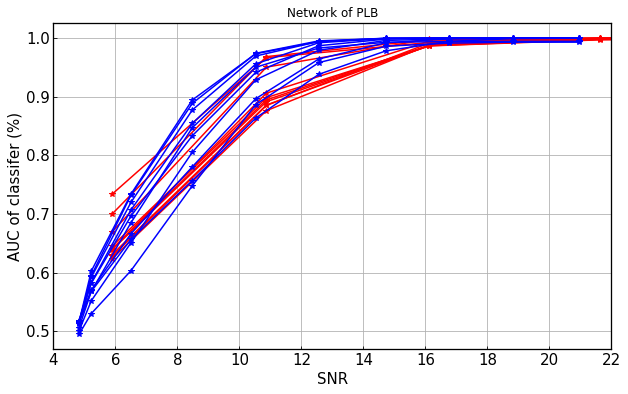

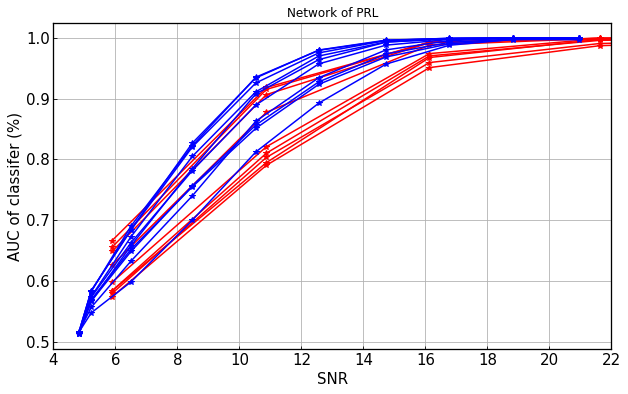

In [48]:
SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

plt.figure(figsize=(10,6))
# with sns.color_palette("Set1_r",20):
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise.npy').tolist()
SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
for i, SNR_ in enumerate(SNR_list):
#     with sns.color_palette("Set1_r",10):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], 'r*-',label = 'OURs+'+index[i])

SNR_MF_list = [20.96, 18.82, 16.77, 14.73, 12.56, 10.53, 8.48, 6.50, 5.22, 4.82]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.load('./AUC_data/AUC_OURs_oldversion.npy').tolist()
for i, SNR_ in enumerate(SNR_list):
#     with sns.color_palette("Set1_r",10):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], 'b*-',label = 'OURs_+'+index[i])

plt.title('Network of OURs')    
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.xlim(4,22)
# plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_oldversion_vs_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
# with sns.color_palette("Set1_r",20):
AUC_OURs = np.load('./AUC_data/AUC_PLB_old_newNoise.npy').tolist()
SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
for i, SNR_ in enumerate(SNR_list):
#     with sns.color_palette("Set1_r",10):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], 'r*-',label = 'OURs+'+index[i])

SNR_MF_list = [20.96, 18.82, 16.77, 14.73, 12.56, 10.53, 8.48, 6.50, 5.22, 4.82]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.load('./AUC_data/AUC_PLB_oldversion.npy').tolist()
for i, SNR_ in enumerate(SNR_list):
#     with sns.color_palette("Set1_r",10):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], 'b*-',label = 'OURs_+'+index[i])

plt.title('Network of PLB')
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.xlim(4,22)
# plt.legend(loc=4)
plt.savefig('./images/AUC_PLB_oldversion_vs_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
# with sns.color_palette("Set1_r",20):
AUC_OURs = np.load('./AUC_data/AUC_PRL_old_newNoise.npy').tolist()
SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
for i, SNR_ in enumerate(SNR_list):
    if SNR_ == 0.8: continue
#     with sns.color_palette("Set1_r",10):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], 'r*-',label = 'OURs+'+index[i])

SNR_MF_list = [20.96, 18.82, 16.77, 14.73, 12.56, 10.53, 8.48, 6.50, 5.22, 4.82]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.load('./AUC_data/AUC_PRL_oldversion.npy').tolist()
for i, SNR_ in enumerate(SNR_list):
#     with sns.color_palette("Set1_r",10):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], 'b*-',label = 'OURs_+'+index[i])

plt.title('Network of PRL')
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.xlim(4,22)
# plt.legend(loc=4)
plt.savefig('./images/AUC_PRL_oldversion_vs_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()

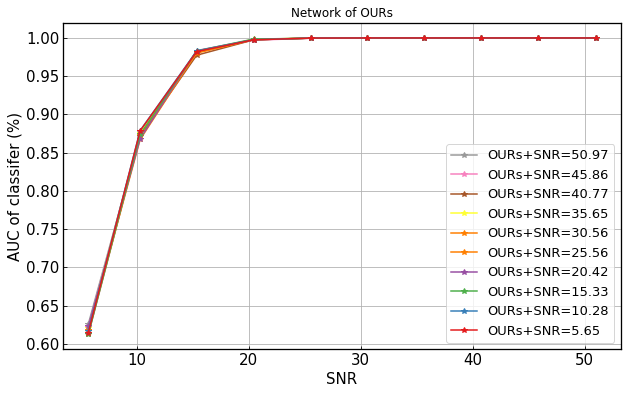

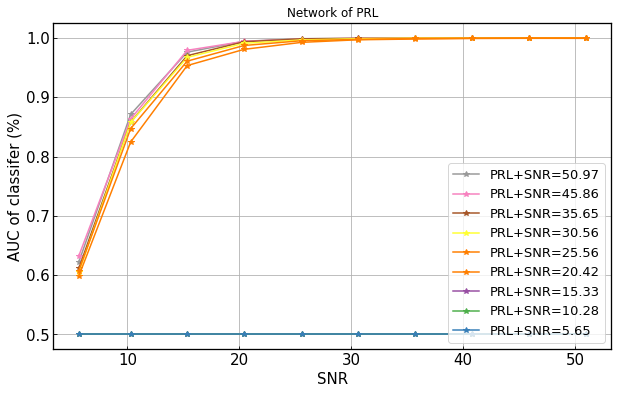

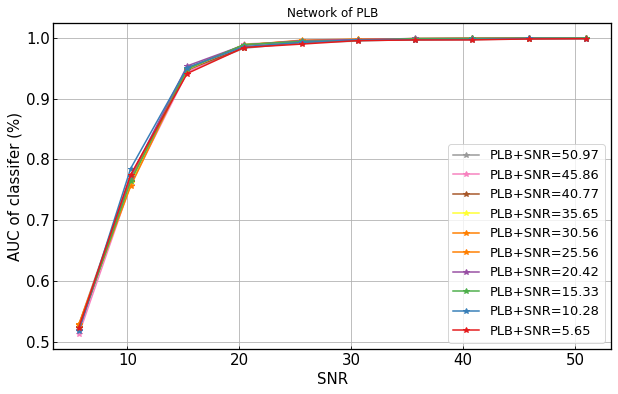

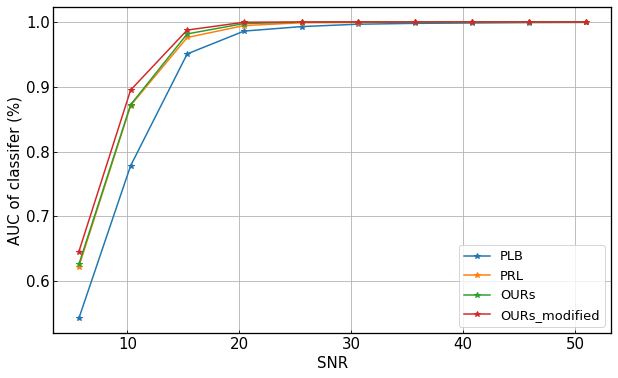

In [62]:
AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_PLB = AUC_PLB[:,1::2,:][:,::-1,:]
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
AUC_OURs_modified = np.load('./AUC_data/AUC_OURs_modified.npy')

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_MF_list = snr_mf_mean[2::2][::-1]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):
        plt.plot(SNR_MF_list[::-1], AUC_OURs.min(axis=2)[i], '*-',label = 'OURs+'+index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_new2.pdf', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    if SNR_ == 0.8: continue
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PRL.min(axis=2)[i] , '*-',label = 'PRL+'+index[i])
plt.grid()
plt.title('Network of PRL')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PRL_new2.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PLB.min(axis=2)[i] , '*-',label = 'PLB+'+index[i])
plt.grid()
plt.xlabel('SNR')
plt.title('Network of PLB')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PLB_new2.pdf', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10,6))
plt.plot(snr_mf_mean[2::2], AUC_PLB.mean(axis=2)[0] , '*-',label = 'PLB')
plt.plot(snr_mf_mean[2::2], AUC_PRL.min(axis=2)[0] , '*-' ,label = 'PRL')
plt.plot(snr_mf_mean[2::2], AUC_OURs.min(axis=2)[0] , '*-',label = 'OURs')
plt.plot(snr_mf_mean[2::2], AUC_OURs_modified.max(axis=2)[0] , '*-',label = 'OURs_modified')
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_models_new2.pdf', dpi=300, bbox_inches='tight')
plt.show()

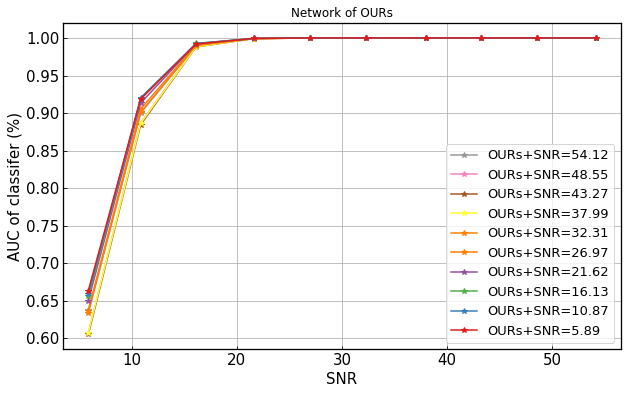

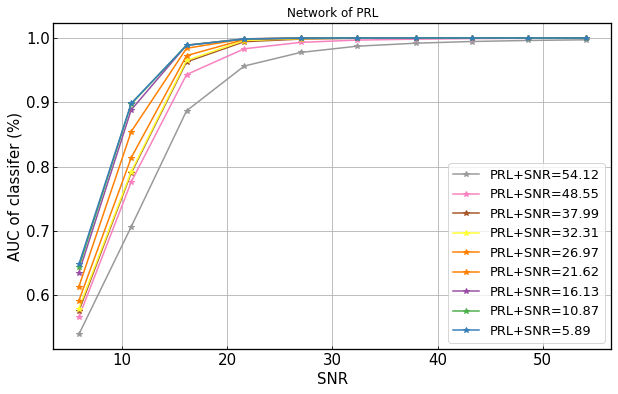

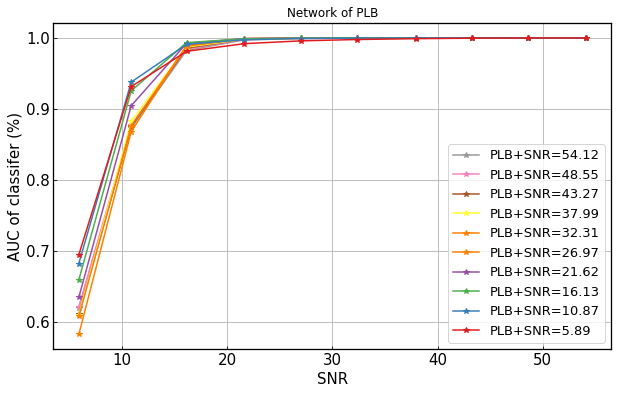

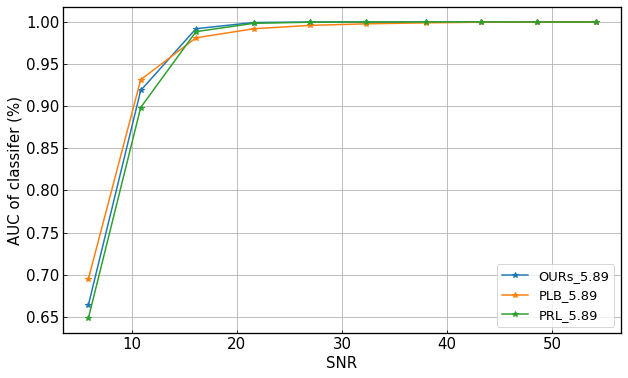

In [9]:
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_localrandom_newNoise.npy').tolist()
AUC_PRL = np.load('./AUC_data/AUC_PRL_old_localrandom_newNoise.npy').tolist()
AUC_PLB = np.load('./AUC_data/AUC_PLB_old_localrandom_newNoise.npy').tolist()

SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):
        plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], '*-',label = 'OURs+'+index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    if SNR_ == 0.8: continue
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(SNR_*10)][::-1] , '*-',label = 'PRL+'+index[i])
plt.grid()
plt.title('Network of PRL')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PRL_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(SNR_*10)][::-1] , '*-',label = 'PLB+'+index[i])
plt.grid()
plt.xlabel('SNR')
plt.title('Network of PLB')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PLB_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10,6))
plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(0.1*10)][::-1] , '*-',label = 'OURs_5.89')
# plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(0.2*10)][::-1] , '*-',label = 'OURs_10.87')
plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(0.1*10)][::-1] , '*-',label = 'PLB_5.89')
# plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(0.2*10)][::-1] , '*-',label = 'PLB_10.87')
plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(0.1*10)][::-1] , '*-',label = 'PRL_5.89')
# plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(0.2*10)][::-1] , '*-',label = 'PRL_10.87')
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_models_old_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [302]:
# SNR_list = np.linspace(0.001, 0.5, num=10).tolist()[::-1]
# SNR_list = np.linspace(0.001, 0.5, num=11*2-1).tolist()[::-1]
# SNR_list = np.linspace(0.001, 0.5, num=11*3-2).tolist()[::-1]
# SNR_list = np.linspace(0.001, 0.5, num=11*4-3).tolist()[::-1]


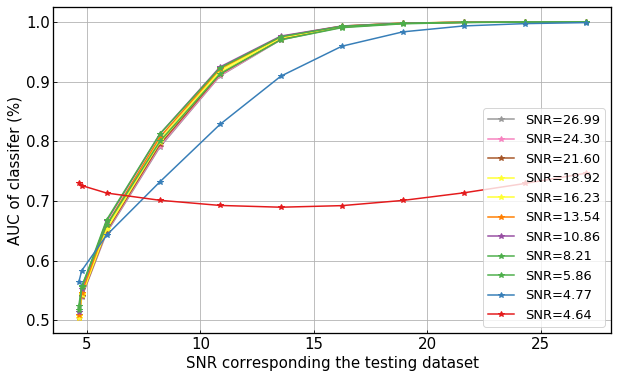

Save or not? (y/n)n


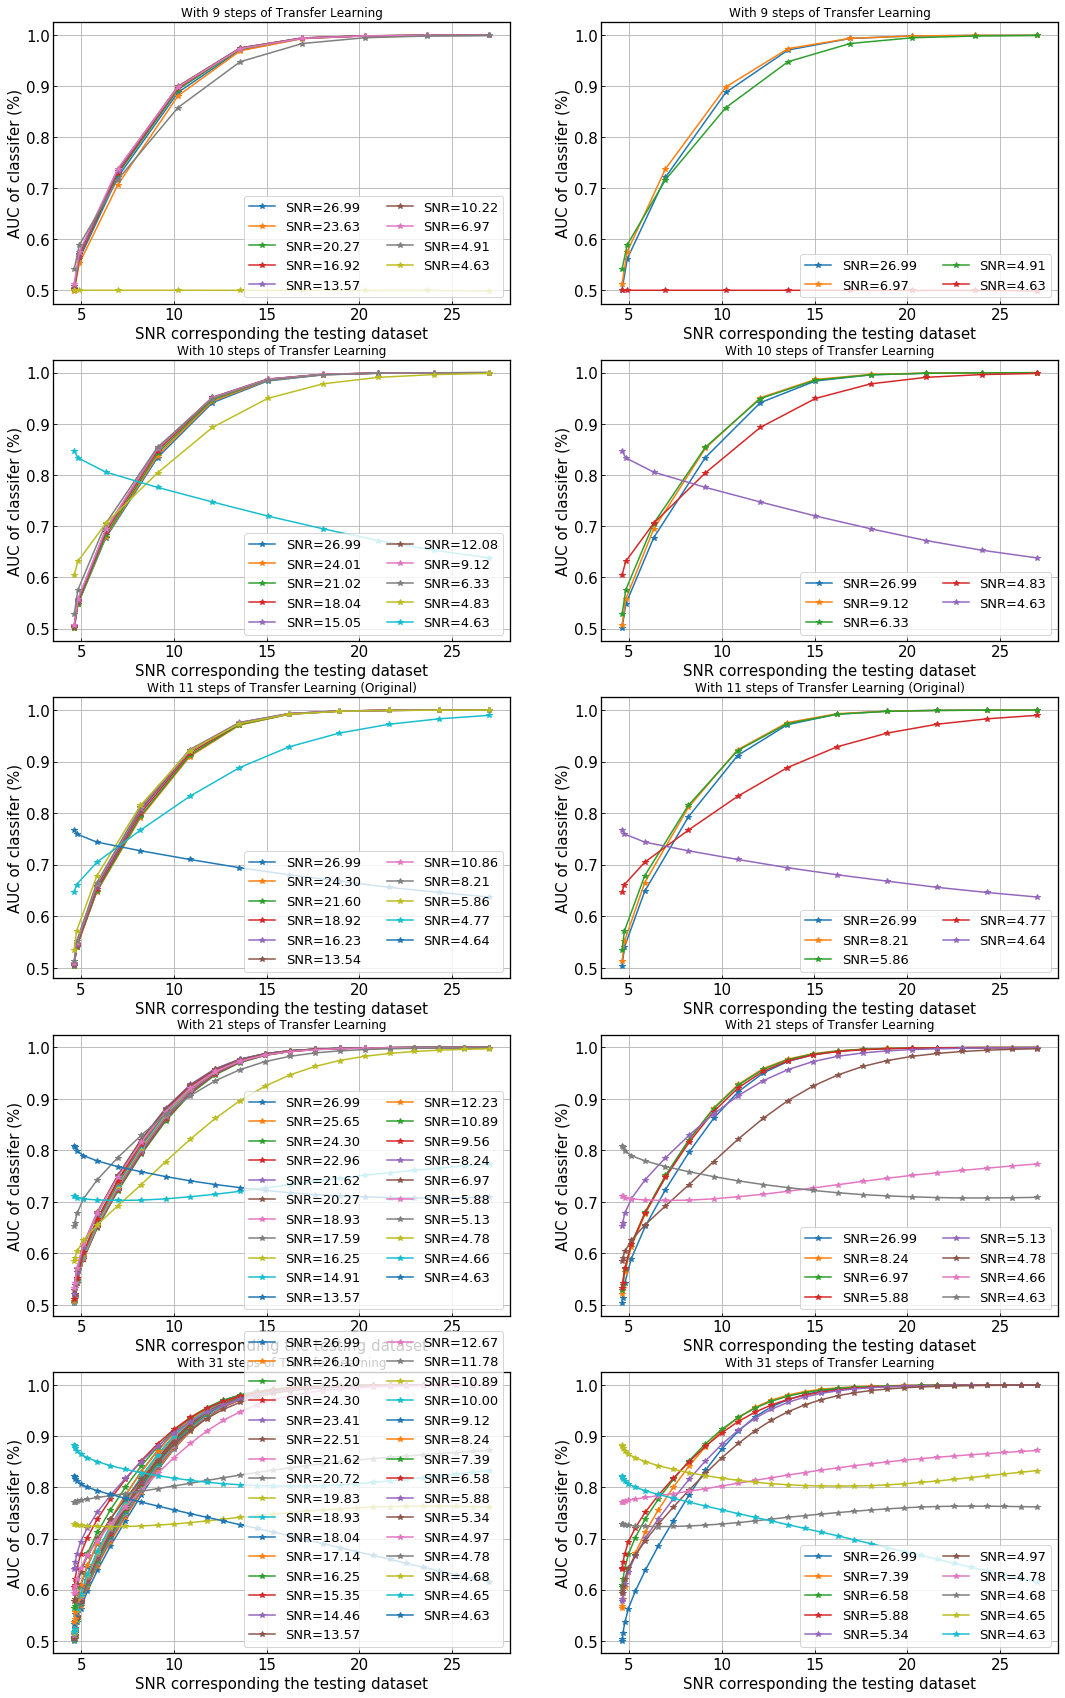

In [384]:
# plt.figure(figsize=(10,6))
# for i, SNR_ in enumerate(SNR_list):
#     with sns.color_palette("Set1_r",len(SNR_list)):
#         plt.plot(SNR_MF_list[::-1] ,AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'SNR='+index[i])
# plt.grid()
# plt.title('Network of OURs')
# plt.xlabel('SNR')
# plt.ylabel('AUC of classifer (%)')
# plt.legend(loc=4)
# # plt.savefig('./images/AUC_OURs_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
# plt.show()
low = None # -2
SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:low]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:low]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()
plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:low], '*-',label = index[i])
plt.grid()
# plt.title('Network of OURs')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.show()

plt.figure(figsize=(18,30))

plt.subplot(5,2,1)
SNR_list = np.linspace(0.001, 0.5, num=9).tolist()[::-1]
SNR_MF_list = [26.99, 23.63, 20.27, 16.92, 13.57, 10.22, 6.97, 4.91, 4.63]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.load('./AUC_data/AUC_old_again_snrnum9.npy').tolist()
# plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[i][::-1], '*-',label = index[i])
plt.grid()
plt.title('With 9 steps of Transfer Learning')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4,ncol=2)
# plt.show()
plt.subplot(5,2,2)
for i, SNR_ in enumerate(SNR_list):
    if ( i <= 5) and (i > 0):
        continue
        pass    
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[i][::-1], '*-',label = index[i])
plt.grid()
plt.title('With 9 steps of Transfer Learning')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4,ncol=2)

plt.subplot(5,2,3)
SNR_list = np.linspace(0.001, 0.5, num=10).tolist()[::-1]
SNR_MF_list = [26.99, 24.01, 21.02, 18.04, 15.05, 12.08, 9.12, 6.33, 4.83, 4.63]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.load('./AUC_data/AUC_old_again_snrnum10.npy').tolist()
# plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[i][::-1], '*-',label = index[i])
plt.grid()
plt.title('With 10 steps of Transfer Learning')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4,ncol=2)
# plt.show()
plt.subplot(5,2,4)
for i, SNR_ in enumerate(SNR_list):
    if ( i <= 5) and (i > 0):
        continue
        pass
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[i][::-1], '*-',label = index[i])
plt.grid()
plt.title('With 10 steps of Transfer Learning')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4,ncol=2)

plt.subplot(5,2,5)
low = None # -2
SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:low]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:low]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.load('./AUC_data/AUC_old_again.npy').tolist()
# plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[:][i][::-1][:], '*-',label = index[i])
plt.grid()
plt.title('With 11 steps of Transfer Learning (Original)')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4, ncol=2)
# plt.show()
plt.subplot(5,2,6)
for i, SNR_ in enumerate(SNR_list):
    if ( i <= 6) and (i > 0):
        continue
        pass
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[:][i][::-1][:], '*-',label = index[i])
plt.grid()
plt.title('With 11 steps of Transfer Learning (Original)')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4, ncol=2)

plt.subplot(5,2,7)
SNR_list = np.linspace(0.001, 0.5, num=11*2-1).tolist()[::-1]
SNR_MF_list = [26.99, 25.65, 24.30, 22.96, 21.62, 20.27, 18.93, 17.59, 16.25, 14.91, 13.57
               , 12.23, 10.89, 9.56, 8.24, 6.97, 5.88, 5.13, 4.78, 4.66, 4.63]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.concatenate((np.load('./AUC_data/AUC_old_again_snrnum10in21.npy'), 
                np.load('./AUC_data/AUC_old_again_snrnum11in21.npy') ), axis=1).tolist()
# plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[i][::-1], '*-',label = index[i])
plt.grid()
plt.title('With 21 steps of Transfer Learning')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4,ncol=2)
# plt.show()
plt.subplot(5,2,8)
for i, SNR_ in enumerate(SNR_list):
    if ( i <= 13) and (i > 0):
        continue
        pass
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[i][::-1], '*-',label = index[i])
plt.grid()
plt.title('With 21 steps of Transfer Learning')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4,ncol=2)

plt.subplot(5,2,9)
SNR_list = np.linspace(0.001, 0.5, num=11*3-2).tolist()[::-1]
SNR_MF_list = [26.99, 26.10, 25.20, 24.30, 23.41, 22.51, 21.62, 20.72, 19.83, 18.93, 18.04, 17.14, 16.25, 15.35, 14.46, 
               13.57, 12.67, 11.78, 10.89, 10.00, 9.12, 8.24, 7.39, 6.58, 5.88, 5.34, 4.97, 4.78, 4.68, 4.65, 4.63]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.concatenate((np.load('./AUC_data/AUC_old_again_snrnum15in31.npy'), 
                np.load('./AUC_data/AUC_old_again_snrnum16in31.npy') ), axis=1).tolist()
# AUC_OURs = np.load('./AUC_data/AUC_old_again_snrnum16in31.npy').tolist()
# plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[i][::-1], '*-',label = index[i])
plt.grid()
plt.title('With 31 steps of Transfer Learning')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4,ncol=2)
plt.subplot(5,2,10)
for i, SNR_ in enumerate(SNR_list):
    if ( i <= 21) and (i > 0):
        continue
        pass
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[i][::-1], '*-',label = index[i])
plt.grid()
plt.title('With 31 steps of Transfer Learning')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4,ncol=2)

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_SNRSTEP'
    for imgtype in ['.png']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()

# 0.09
# SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1,0.09, 0.05, 0.01][3:low]
# SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 5.51, 4.77, 4.64][3:low]
# index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
# AUC_OURs = np.load('./AUC_data/AUC_old_again_snr09.npy').tolist()
# plt.figure(figsize=(10,6))
# for i, SNR_ in enumerate(SNR_list):

#     if( i <= 6) and (i > 0) :
#         continue
#         pass
#     with sns.color_palette("Set1_r",5):
#         plt.plot(SNR_MF_list[::-1] ,AUC_OURs[:][i][::-1][:], '*-',label = index[i])
# plt.grid()
# # plt.xscale('log')
# # plt.title('Network of OURs')
# plt.xlabel('SNR corresponding the testing dataset')
# plt.ylabel('AUC of classifer (%)')
# plt.legend(loc=4, ncol=2)
# if input('Save or not? (y/n)') == 'y':
#     save_address = './images/'
#     name = 'ACC_OURs_snr09_'
#     for imgtype in ['.png']:
#         plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
#         print('Saved in '+save_address+ name + imgtype)
# else:
#     pass
# plt.show()

# 0.08
# SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1,0.08, 0.05, 0.01][3:low]
# SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 5.23, 4.77, 4.64][3:low]
# index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
# AUC_OURs = np.load('./AUC_data/AUC_old_again_snr08.npy').tolist()
# plt.figure(figsize=(10,6))
# for i, SNR_ in enumerate(SNR_list):
#     if( i <= 6) and (i > 0) :
#         continue
#         pass
#     with sns.color_palette("Set1_r",6):
#         plt.plot(SNR_MF_list[::-1] ,AUC_OURs[:][i][::-1][:], '*-',label = index[i])
# plt.grid()
# # plt.xscale('log')
# # plt.title('Network of OURs')
# plt.xlabel('SNR corresponding the testing dataset')
# plt.ylabel('AUC of classifer (%)')
# plt.legend(loc=4, ncol=2)
# if input('Save or not? (y/n)') == 'y':
#     save_address = './images/'
#     name = 'ACC_OURs_snr08_'
#     for imgtype in ['.png']:
#         plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
#         print('Saved in '+save_address+ name + imgtype)
# else:
#     pass
# plt.show()

Save or not? (y/n)y
Saved in ./images/ACC_SNRSTEP5in31.png
Saved in ./images/ACC_SNRSTEP5in31.eps
Saved in ./images/ACC_SNRSTEP5in31.pdf


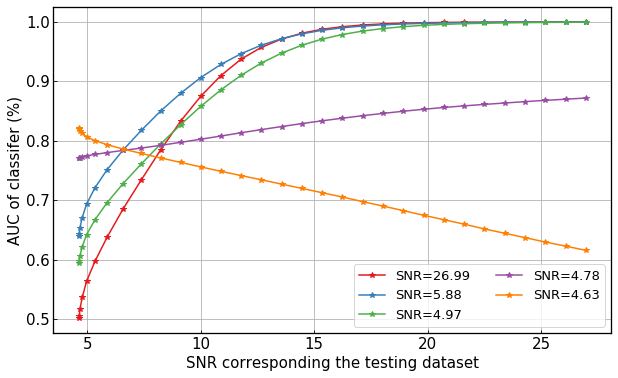

In [368]:
SNR_list = np.linspace(0.001, 0.5, num=11*3-2).tolist()[::-1]
SNR_MF_list = [26.99, 26.10, 25.20, 24.30, 23.41, 22.51, 21.62, 20.72, 19.83, 18.93, 18.04, 17.14, 16.25, 15.35, 14.46, 
               13.57, 12.67, 11.78, 10.89, 10.00, 9.12, 8.24, 7.39, 6.58, 5.88, 5.34, 4.97, 4.78, 4.68, 4.65, 4.63]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.concatenate((np.load('./AUC_data/AUC_old_again_snrnum15in31.npy'), 
                np.load('./AUC_data/AUC_old_again_snrnum16in31.npy') ), axis=1).tolist()
plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    if (i==28) or (i == 29) or (i==25) or ( i <= 23) and (i > 0):
        continue
        pass
    with sns.color_palette("Set1",5):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[i][::-1], '*-',label = index[i])
plt.grid()
# plt.title('With 31 steps of Transfer Learning')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4,ncol=2)

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_SNRSTEP5in31'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()

Save or not? (y/n)n


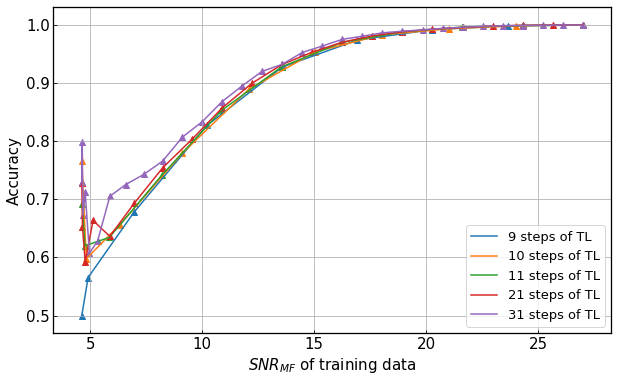

In [386]:
plt.figure(figsize=(10,6))
SNR_MF_list = [26.99, 23.63, 20.27, 16.92, 13.57, 10.22, 6.97, 4.91, 4.63]
ACC_train_list = np.load('./AUC_data/ACC_old_again_snrnum9.npy').tolist()
ACC_train_list = [value[index] for index, value in enumerate(ACC_train_list)]
plt.plot(SNR_MF_list[::-1] ,ACC_train_list[::-1],'-', label = '9 steps of TL')
plt.scatter(SNR_MF_list[::-1] ,ACC_train_list[::-1],marker='^', )

SNR_MF_list = [26.99, 24.01, 21.02, 18.04, 15.05, 12.08, 9.12, 6.33, 4.83, 4.63]
ACC_train_list = np.load('./AUC_data/ACC_old_again_snrnum10.npy').tolist()
ACC_train_list = [value[index] for index, value in enumerate(ACC_train_list)]
plt.plot(SNR_MF_list[::-1] ,ACC_train_list[::-1],'-', label = '10 steps of TL')
plt.scatter(SNR_MF_list[::-1] ,ACC_train_list[::-1],marker='^', )

low = None # -2
SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:low]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:low]
# ACC_train_list = []
# address = './AUC_data/'
# for SNR_ in SNR_list:
#     test_file = [add for add in os.listdir(address) if 'test_OURsSNR%s_accuracy_history' %int(SNR_*100) in add ][0]
#     index_ = nd.load(address + test_file)[0].asnumpy().argmax()
#     train_file = [add for add in os.listdir(address) if 'train_OURsSNR%s_accuracy_history' %int(SNR_*100) in add ][0]
#     ACC_train_list.append(nd.load(address + train_file)[0].asnumpy()[index_])
# or
ACC_train_list = np.load('./AUC_data/ACC_old_again.npy').tolist()
ACC_train_list = [value[index] for index, value in enumerate(ACC_train_list)]
plt.plot(SNR_MF_list[::-1] ,ACC_train_list[::-1],'-',label = '11 steps of TL')
plt.scatter(SNR_MF_list[::-1] ,ACC_train_list[::-1],marker='^', )

SNR_MF_list = [26.99, 25.65, 24.30, 22.96, 21.62, 20.27, 18.93, 17.59, 16.25, 14.91, 13.57
               , 12.23, 10.89, 9.56, 8.24, 6.97, 5.88, 5.13, 4.78, 4.66, 4.63]
ACC_train_list = np.concatenate((np.load('./AUC_data/ACC_old_again_snrnum10in21.npy'), 
                np.load('./AUC_data/ACC_old_again_snrnum11in21.npy')) , axis=1).tolist()
ACC_train_list = [value[index] for index, value in enumerate(ACC_train_list)]
plt.plot(SNR_MF_list[::-1] ,ACC_train_list[::-1],'-', label = '21 steps of TL')
plt.scatter(SNR_MF_list[::-1] ,ACC_train_list[::-1],marker='^', )

SNR_MF_list = [26.99, 26.10, 25.20, 24.30, 23.41, 22.51, 21.62, 20.72, 19.83, 18.93, 18.04, 17.14, 16.25, 15.35, 14.46, 
               13.57, 12.67, 11.78, 10.89, 10.00, 9.12, 8.24, 7.39, 6.58, 5.88, 5.34, 4.97, 4.78, 4.68, 4.65, 4.63]
ACC_train_list = np.concatenate((np.load('./AUC_data/ACC_old_again_snrnum15in31.npy'), 
                np.load('./AUC_data/ACC_old_again_snrnum16in31.npy')) , axis=1).tolist()
ACC_train_list = [value[index] for index, value in enumerate(ACC_train_list) ]
plt.plot(SNR_MF_list[::-1] ,ACC_train_list[::-1],'-', label = '31 steps of TL')
plt.scatter(SNR_MF_list[::-1] ,ACC_train_list[::-1],marker='^', )
# plt.plot(SNR_MF_list[::-1] ,ACC_train_list[::-1],'r-')
# plt.scatter(SNR_MF_list[::-1] ,ACC_train_list[::-1],marker='^', c='lime')
plt.grid()
plt.xlabel('$SNR_{MF}$ of training data')
plt.ylabel('Accuracy')
plt.legend(loc=4)
# plt.savefig('./images/AUC_OURs_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_Traindata'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()

In [323]:
np.load('./AUC_data/ACC_old_again_snrnum16in31.npy')[15:,:].shape

(16, 16)

[0.6226156949996948, 0.8257406949996948, 0.6760856509208679, 0.7204748392105103, 0.719663143157959, 0.7021104097366333, 0.7512175440788269, 0.8199066519737244, 0.8655133843421936, 0.912895679473877, 0.9364854097366333, 0.9576907753944397, 0.9733664989471436, 0.9841213226318359, 0.9891436696052551, 0.9923903942108154, 0.9956879019737244, 0.9977171421051025, 0.9987317323684692, 0.9997971057891846, 0.9998985528945923]


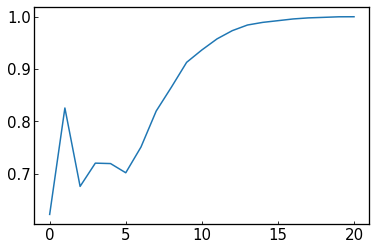

In [315]:
ACC_train_list = np.concatenate((np.load('./AUC_data/ACC_old_again_snrnum10in21.npy'), 
                np.load('./AUC_data/ACC_old_again_snrnum11in21.npy')) , axis=1).tolist()
ACC_train_list = [value[index] for index, value in enumerate(ACC_train_list)]
print(ACC_train_list[::-1])
plt.plot(ACC_train_list[::-1])

Save or not? (y/n)n


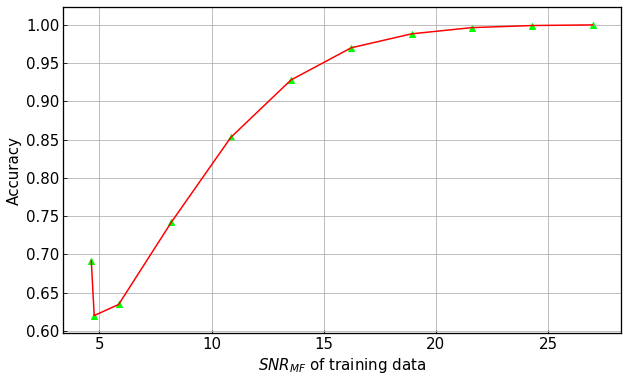

Save or not? (y/n)n


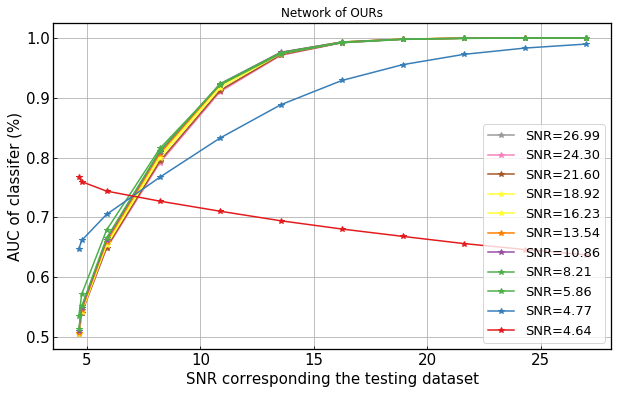

Save or not? (y/n)n


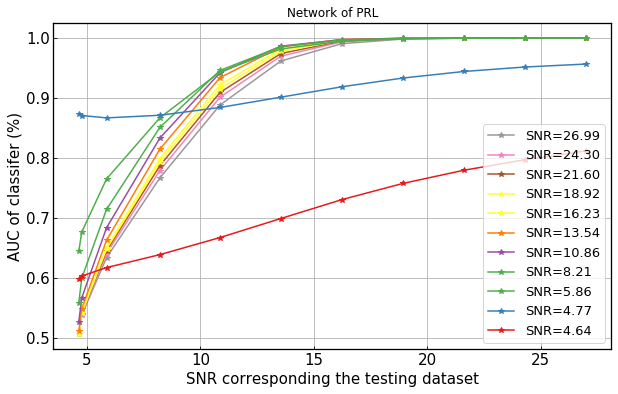

Save or not? (y/n)n


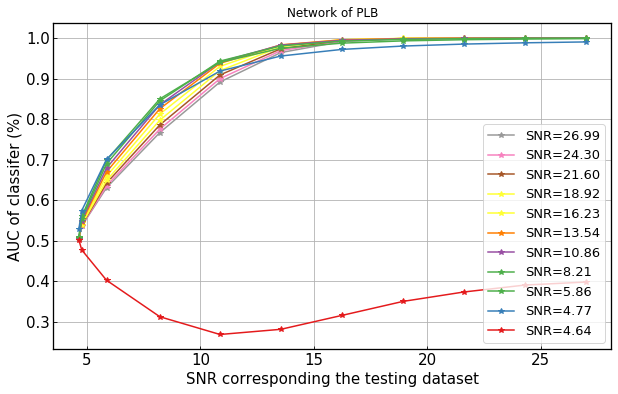

Save or not? (y/n)n


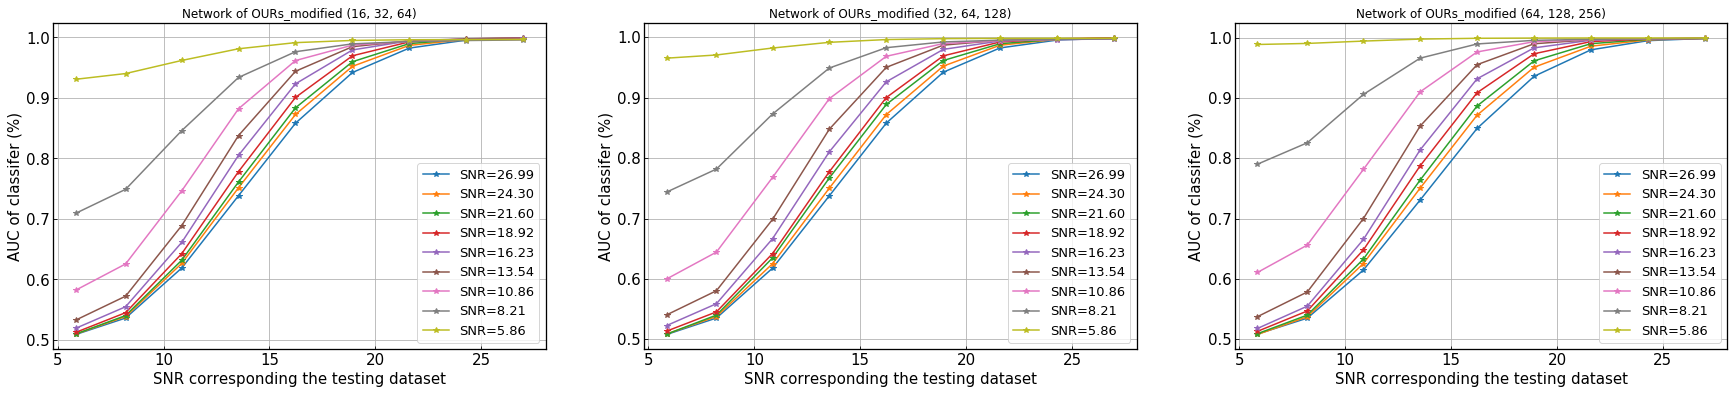

Save or not? (y/n)n


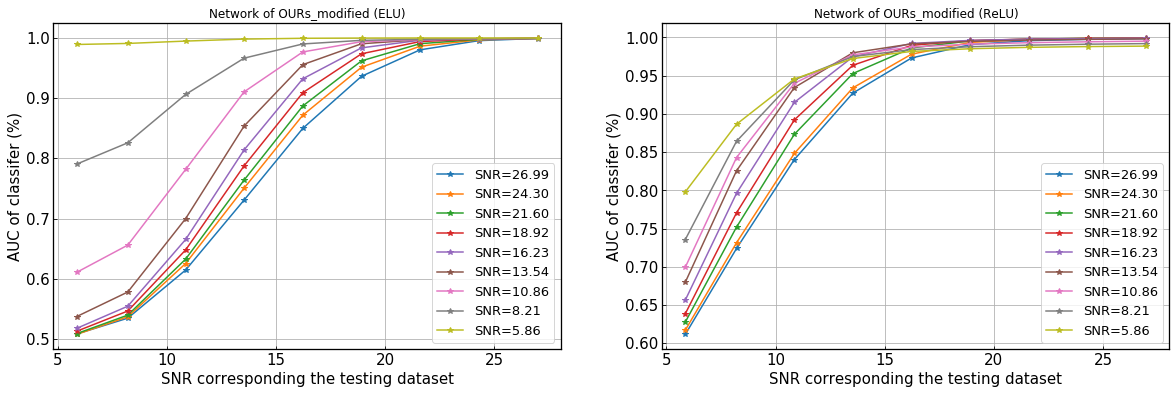

Save or not? (y/n)y
Saved in ./images/ACC_models_compare.png
Saved in ./images/ACC_models_compare.eps
Saved in ./images/ACC_models_compare.pdf


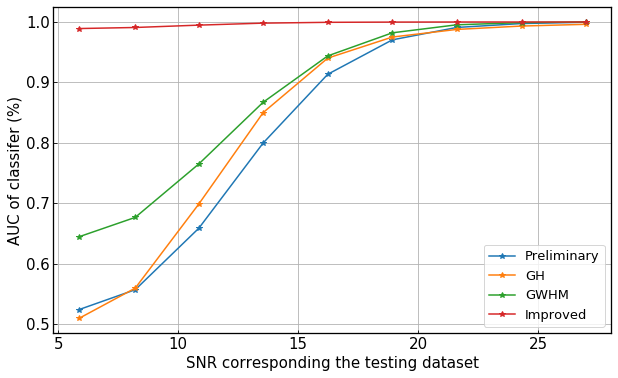

In [370]:
low = None # -2
SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:low]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:low]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

ACC_train_list = []
address = './AUC_data/'
for SNR_ in SNR_list:
    test_file = [add for add in os.listdir(address) if 'test_OURsSNR%s_accuracy_history' %int(SNR_*100) in add ][0]
    index_ = nd.load(address + test_file)[0].asnumpy().argmax()
    train_file = [add for add in os.listdir(address) if 'train_OURsSNR%s_accuracy_history' %int(SNR_*100) in add ][0]
    ACC_train_list.append(nd.load(address + train_file)[0].asnumpy()[index_])
# or
# ACC_train_list = np.load('./AUC_data/ACC_old_again.npy').tolist()
# ACC_train_list = [value[index] for index, value in enumerate(ACC_train_list)]

AUC_OURs = np.load('./AUC_data/AUC_old_again.npy').tolist()
AUC_PRL = np.load('./AUC_data/AUC_PRL_old_newNoise_newSNRlist.npy').tolist()
AUC_PLB = np.load('./AUC_data/AUC_PLB_old_newNoise_newSNRlist.npy').tolist()
AUC_OURs_modified_nf1 = np.load('./AUC_data/AUC_OURs_old_newNoise_OURs_modified1.npy').tolist()
AUC_OURs_modified_nf2 = np.load('./AUC_data/AUC_OURs_old_newNoise_OURs_modified2.npy').tolist()
AUC_OURs_modified_nf4 = np.load('./AUC_data/AUC_OURs_old_newNoise_OURs_modified4.npy').tolist()
AUC_OURs_modified_nf4_relu = np.load('./AUC_data/AUC_OURs_old_newNoise_OURs_modified4_relu.npy').tolist()


plt.figure(figsize=(10,6))
plt.plot(SNR_MF_list[::-1] ,ACC_train_list[::-1],'r-')
plt.grid()
plt.scatter(SNR_MF_list[::-1] ,ACC_train_list[::-1],marker='^', c='lime')
plt.xlabel('$SNR_{MF}$ of training data')
plt.ylabel('Accuracy')
# plt.legend(loc=4)
# plt.savefig('./images/AUC_OURs_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_Traindata'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()



plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[:][i][::-1][:], '*-',label = index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_OURs_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'AUC_Testdata'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()



plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):    
        plt.plot(SNR_MF_list[::-1] ,AUC_PRL['%s' %int(SNR_*100)][3:][::-1][:low] , '*-',label = index[i])
plt.grid()
plt.title('Network of PRL')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_PRL_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_PRL_Testdata'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()


plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_PLB['%s' %int(SNR_*100)][3:][::-1][:low] , '*-',label = index[i])
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.title('Network of PLB')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_PLB_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_PLB_Testdata'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()

SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)
plt.figure(figsize=(30,6))
plt.subplot(1,3,1)
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):    
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf1['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = index[i])
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.title('Network of OURs_modified '+'%s' %str((16*1,32*1,64*1)))
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_PLB_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(10,6))
plt.subplot(1,3,2)
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):    
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf2['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = index[i])
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.title('Network of OURs_modified '+'%s' %str((16*2,32*2,64*2)))
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_PLB_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(10,6))
plt.subplot(1,3,3)
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):    
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf4['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = index[i])
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.title('Network of OURs_modified '+'%s' %str((16*4,32*4,64*4)))
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_OURs_modified_nf_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_OURs_modified_featuremaps'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()


plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):    
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf4['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = index[i])
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.title('Network of OURs_modified (ELU)')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_PLB_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
# plt.show()


plt.subplot(1,2,2)
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):    
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf4_relu['%s' %int(SNR_*100)][::-1] , '*-',label = index[i])
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.title('Network of OURs_modified (ReLU)')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_OURs_modified_acc_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    name = 'ACC_OURs_modified_ReLUvsELU'
    for imgtype in ['.png','.eps','.pdf']:
        plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
        print('Saved in '+save_address+ name + imgtype)
else:
    pass
plt.show()


AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()
for i, SNR_ in enumerate(SNR_list[::-1]):
    plt.figure(figsize=(10,6))
    plt.plot(SNR_MF_list[::-1] ,AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'Preliminary')
    plt.plot(SNR_MF_list[::-1] ,AUC_PLB['%s' %int(SNR_*100)][3:][::-1][:-2] , '*-',label = 'GH')
    plt.plot(SNR_MF_list[::-1] ,AUC_PRL['%s' %int(SNR_*100)][3:][::-1][:-2] , '*-',label = 'GWHM')
#     plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf1['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = 'OURs_modified '+'%s' %str((16*1,32*1,64*1)))
#     plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf2['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = 'OURs_modified '+'%s' %str((16*2,32*2,64*2)))
#     plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf4['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = 'OURs_modified '+'%s' %str((16*4,32*4,64*4)))
#     plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf4_relu['%s' %int(SNR_*100)][::-1] , '*-',label = 'OURs_modified '+'%s (ReLU)' %str((16*4,32*4,64*4)))
    plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf4['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = 'Improved')    
    plt.grid()
    plt.xlabel('SNR corresponding the testing dataset')
    plt.ylabel('AUC of classifer (%)')
    plt.legend(loc=4)
#     plt.savefig('./images/AUC_models_oldnewNoise_newSNRlist.pdf', dpi=300, bbox_inches='tight')
    if input('Save or not? (y/n)') == 'y':
        save_address = './images/'
        name = 'ACC_models_compare'
        for imgtype in ['.png','.eps','.pdf']:
            plt.savefig(save_address + name + imgtype, dpi = 300, bbox_inches = 'tight')
            print('Saved in '+save_address+ name + imgtype)
    else:
        pass
    plt.show()
    break
    


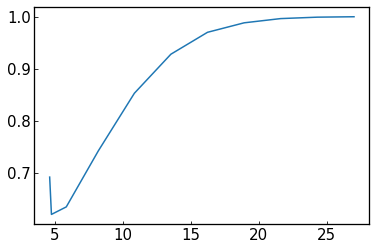

In [51]:
# plt.plot(fpr_old_again[10][10])
ACC = np.load('./AUC_data/ACC_old_again.npy').tolist()

11

In [17]:
AUC

[[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]

In [16]:
ACC = np.load('./AUC_data/ACC_OURs_old_newNoise.npy')
AUC = np.load('./AUC_data/AUC_OURs_old_newNoise_training.npy').tolist()
AUC = np.load('./AUC_data/AUC_OURs_old_newNoise_testing.npy').tolist()

low = None # -2
SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:low]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:low]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)


plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC['%s' %int(SNR_*100)][3:][::-1][:low], '*-',label = index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_OURs_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
plt.show()

TypeError: list indices must be integers or slices, not str

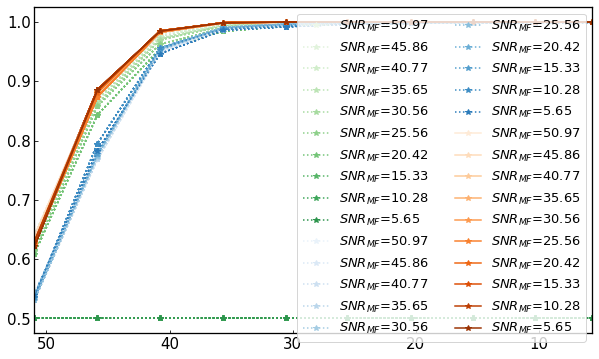

In [55]:
AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_PLB = AUC_PLB[:,1::2,:][:,::-1,:]
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
AUC_OURs_modified = np.load('./AUC_data/AUC_OURs_modified.npy')
# AUC_OURs_2localnoise1 = np.load('./AUC_data/AUC_OURs_2localnoise1.npy')
# AUC_OURs_2localnoise5 = np.load('./AUC_data/AUC_OURs_2localnoise5.npy')
# AUC_OURs_2localnoise10 = np.load('./AUC_data/AUC_OURs_2localnoise10.npy')
# AUC_OURs_new3_localnoise = np.load('./AUC_data/AUC_OURs_new3_localnoise.npy')

# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)



df = pd.DataFrame(AUC_PRL.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=snr_mf_mean[2::2][::-1])
for i in range(AUC_PRL.shape[0]):
    df.T.plot(marker= '*',linestyle=':', ax=ax, color=sns.color_palette('Greens', 13), alpha = 1)    
    
df = pd.DataFrame(AUC_PLB.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=snr_mf_mean[2::2][::-1])
for i in range(AUC_PLB.shape[0]):
    df.T.plot(marker= '*',linestyle=':', ax=ax, color=sns.color_palette('Blues', 13), alpha = 1)    

df = pd.DataFrame(AUC_OURs.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=snr_mf_mean[2::2][::-1])    
for i in range(AUC_OURs.shape[0]):
    df.T.plot(marker= '*', ax=ax, color=sns.color_palette("Oranges", 10), alpha = 1)

ax.legend(ncol=2, loc='best')
# ax.set_xlim(0.09, 1.01)
# ax.set_ylabel('AUC of classifier (%)')
# ax.set_xlabel('SNR corresponding the testing dataset')
# ax.grid()
# if input('Save or not? (y/n)') == 'y':
#     save_address = './images/'
#     plt.savefig(save_address + 'AUC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
#     plt.savefig(save_address + 'AUC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
#     print('Saved in '+save_address+'AUC_comparison_training.eps')
# else:
#     pass
plt.show()

In [50]:
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

In [54]:
snr_mf_mean

array([  4.63982857,   4.74113166,   5.65292862,   7.77442809,
        10.28243198,  12.8157135 ,  15.33320026,  17.88634635,
        20.41547708,  22.97701746,  25.55851639,  28.08865864,
        30.55795145,  33.20315601,  35.64628161,  38.25031812,
        40.76856555,  43.3313526 ,  45.85824238,  48.35261292,  50.97136133])

In [43]:
from models.ConvNet import *

In [212]:
pool = 16
nf = 4
ConvNet(conv_params = {'kernel': ((1,16), (1,8), (1,8),), 
                                    'num_filter': (int(16*nf), int(32*nf), int(64*nf),),
                                    'stride': ((1,1), (1,1), (1,1),),
                                    'padding': ((0,0), (0,0), (0,0),),
                                    'dilate': ((1,3), (1,3), (1,3),)},
                        act_params = {'act_type': ('relu', 'relu', 'relu','relu',)},
                        pool_params = {'pool_type': ('avg', 'avg', 'avg',),
                                    'kernel': ((1,pool), (1,pool), (1,pool),),
                                    'stride': ((1,2), (1,2), (1,2),),
                                    'padding': ((0,0),(0,0), (0,0)),
                                    'dilate': ((1,1), (1,1), (1,1),)},
                        fc_params = {'hidden_dim': (128,)}, drop_prob = 0.75, 
#                         input_dim = (2,1,8192)
                        input_dim = (1,1,8192)
                    )

W1 (64, 1, 1, 16) b1 (64,)
W2 (128, 64, 1, 8) b2 (128,)
W3 (256, 128, 1, 8) b3 (256,)
W4 (253440, 128) b4 (128,)
W5 (128, 2) b5 (2,)
------------
Weight dims: 3.276928e+07
Bias dims: 5.780000e+02
------------
